In [2]:
# from __future__ import print_function, division
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import h5py

import os
import tarfile
import pandas as pd

from PyAstronomy import pyasl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from scipy import stats
import scipy.interpolate as sci
from scipy.stats import sigmaclip as sigmaclip
from scipy.ndimage import gaussian_filter1d
from scipy.interpolate import make_interp_spline
from scipy.interpolate import interp1d
from scipy.signal import find_peaks
from sklearn.preprocessing import MinMaxScaler

import astropy.io.fits as fits
import astropy.time as time
import astropy.coordinates as coords
import astropy.units as u
from astropy.time import Time
import astropy.constants as const
from astropy.constants import c # speed of light

from tabulate import tabulate



Telluric part 0


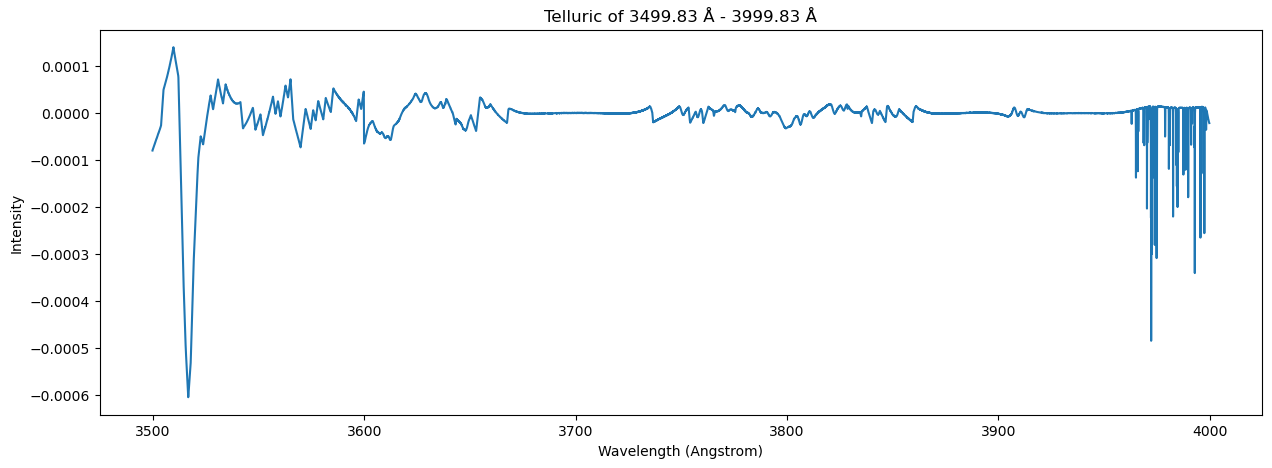

Telluric part 1


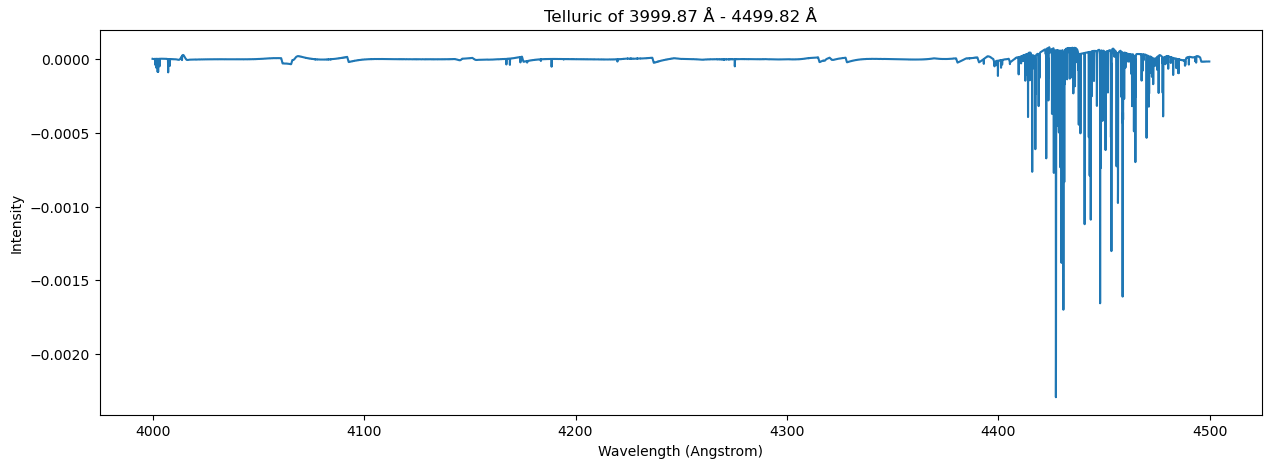

Telluric part 2


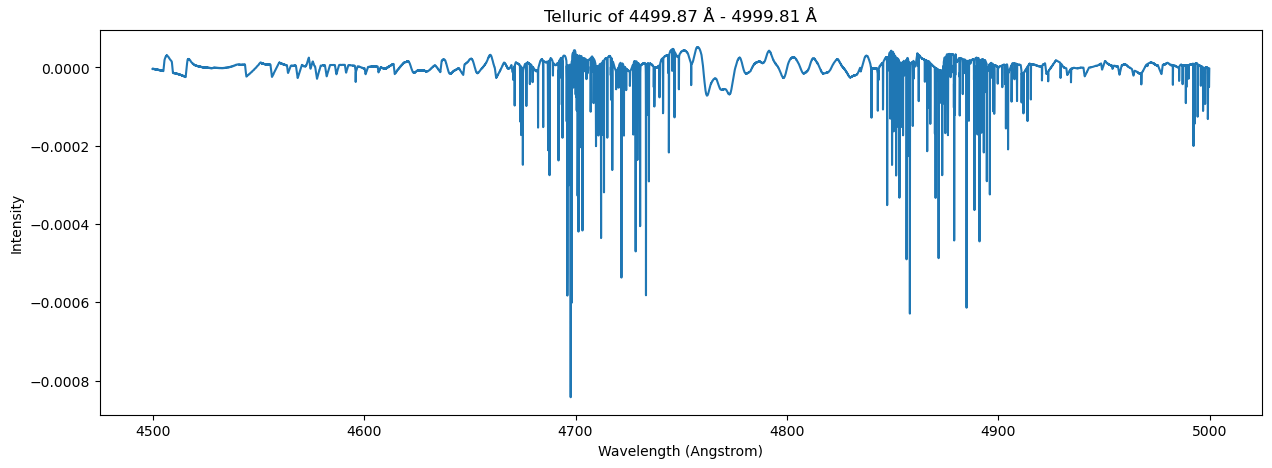

Telluric part 3


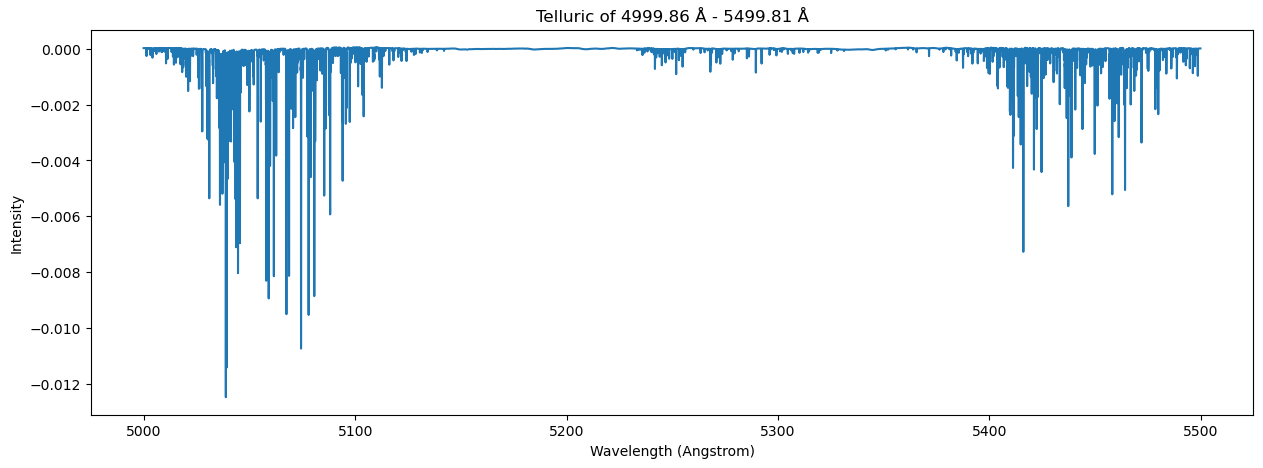

Telluric part 4


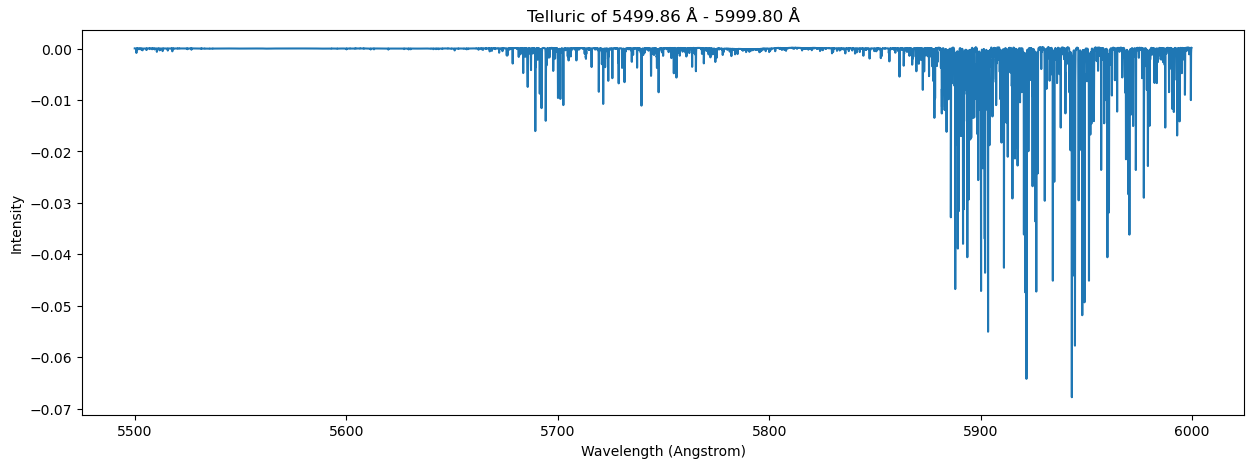

Telluric part 5


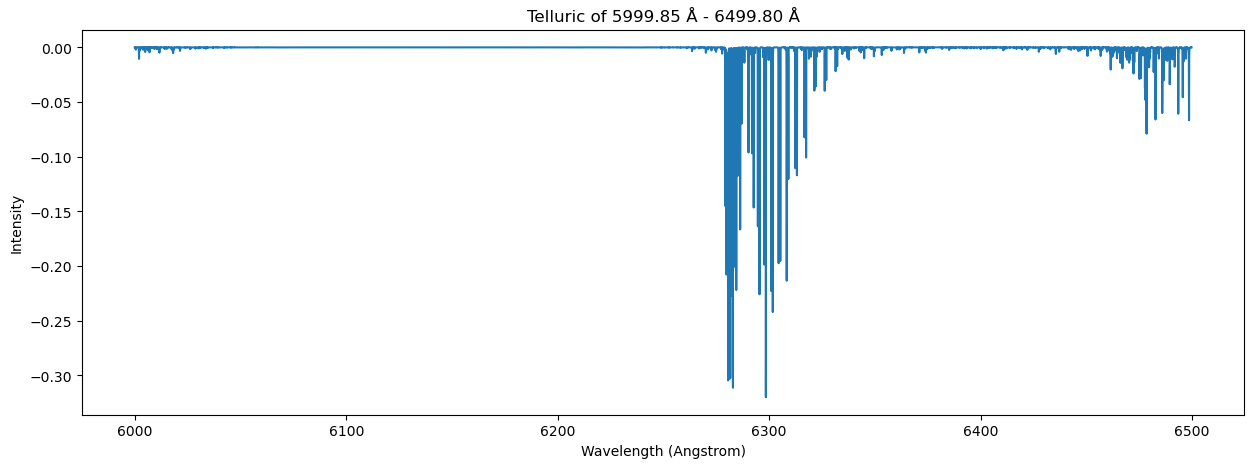

Telluric part 6


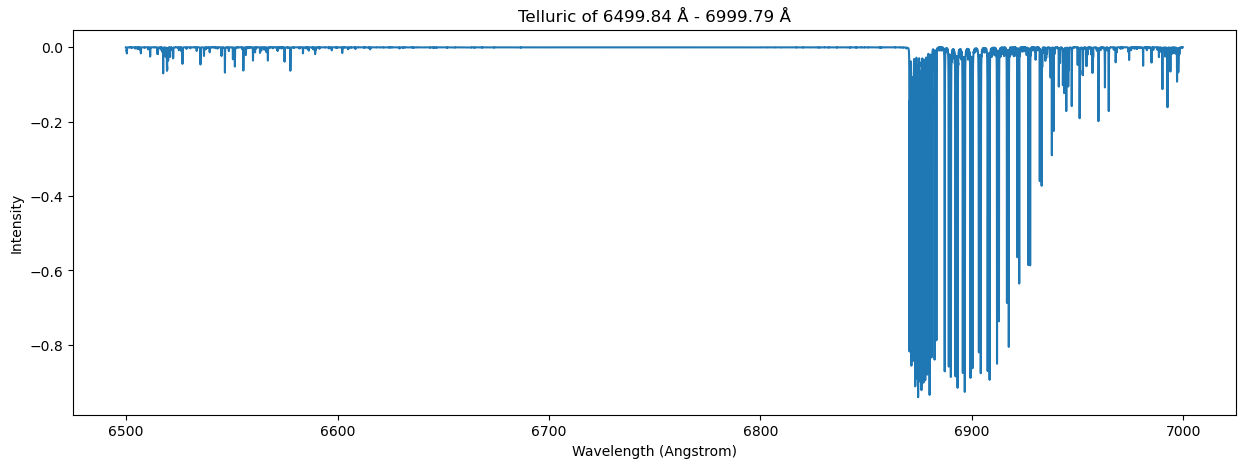

Telluric part 7


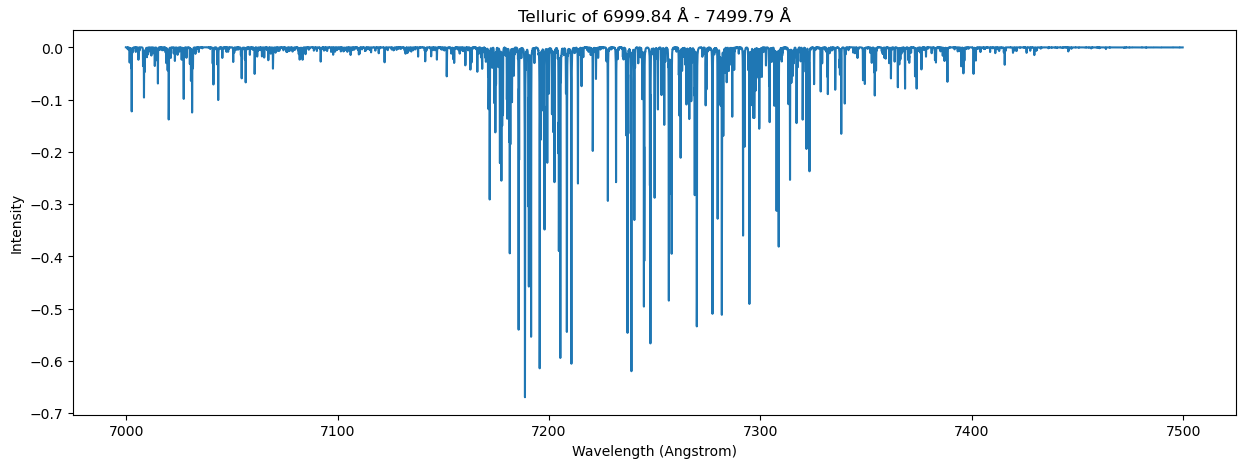

Telluric part 8


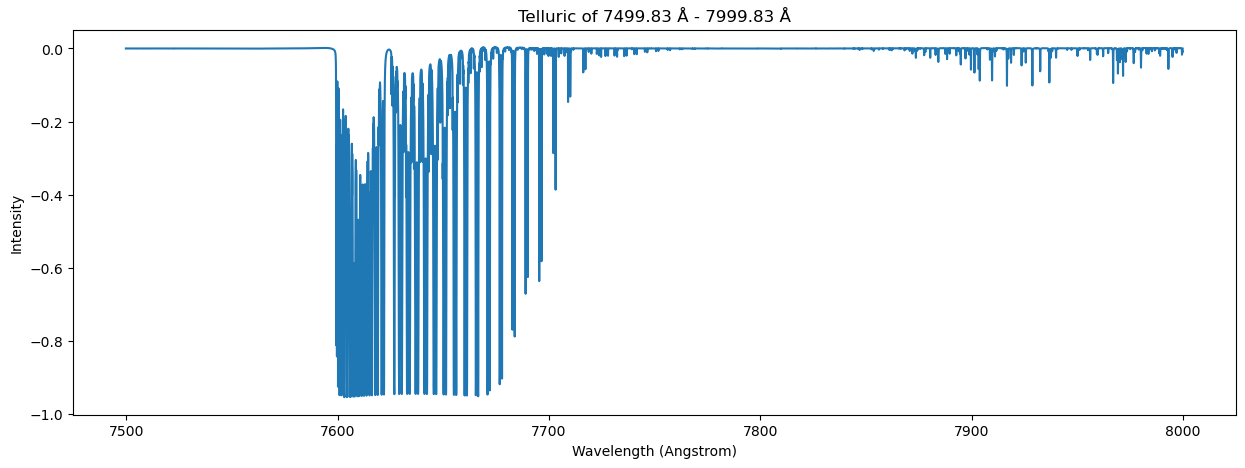

Combining all continuum telluric


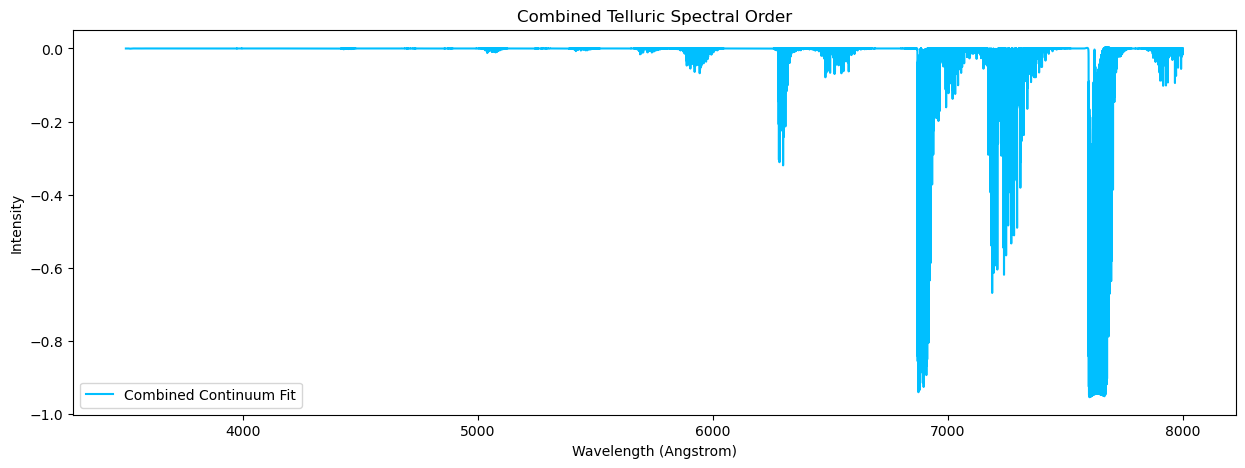

NameError: name 'normalize_data' is not defined

In [2]:
continuum_trans = []
wv_telluric = []

# Read and process data, plot fitting and continuum spectral order, and save each DataFrame to CSV
for i in range(1,10):    
    # Read data
    df = pd.read_csv(f'./lineprofil/telluric-167971/telluricsplitorder{i}.csv')
    df = df.drop(df.index[0]) # remove unused string row
    df['Subtracted_Data Y1'] = pd.to_numeric(df['Subtracted_Data Y1']) # convert string to numeric
    df['tellurictrans'] = df['Subtracted_Data Y1'] # normalized flux
    
    df['telluricwv'] = df['Unnamed: 0'] # wavelength in angstrom
    
    wv_telluric.append(df['telluricwv'])
    continuum_trans.append(df['tellurictrans'])
    
    print(f'Telluric part {i-1}')
    
    # Plot continuum telluric 
    plt.figure(figsize=(15,5))
    plt.plot(df['telluricwv'],df['tellurictrans'])
    plt.title(f"Telluric of {df['telluricwv'].min():.2f} Å - {df['telluricwv'].max():.2f} Å")
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.show()
    
# Concatenate data and plot combined continuum spectral order
telluricwv_combined = np.concatenate(wv_telluric)
telluriccont_combined = np.concatenate(continuum_trans)
print('Combining all continuum telluric')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined, telluriccont_combined, c='deepskyblue',label='Combined Continuum Fit')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

telluriccont_combined = normalize_data(telluriccont_combined)

print('Combining all continuum telluric scaled')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined, telluriccont_combined, c='deepskyblue')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

np.savetxt('telluric_167971.txt', np.column_stack((telluricwv_combined, telluriccont_combined)), delimiter=' ', header='wv flux', comments='')


In [140]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis(n,k,s,beginning,ending,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD167971')
    plt.plot(telluricwv_combined+k, telluriccont_combined+s, c='deepskyblue', label='telluric',alpha=0.45)
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.75,label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey', linestyle='dashed')
    plt.axvline(x=ending, color='grey', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")

               WV   fluxori  fluxsmooth
1     6244.101384  1.003098    1.003231
2     6244.111798  1.001999    1.003223
3     6244.122212  1.006763    1.003204
4     6244.132625  1.000825    1.003179
5     6244.143039  1.006359    1.003148
...           ...       ...         ...
6712  6314.380132  1.003926    1.004921
6713  6314.390663  1.009254    1.004901
6714  6314.401194  1.007342    1.004892
6715  6314.411725  1.005783    1.004898
6716  6314.422256  1.010210    1.004916

[6716 rows x 3 columns]


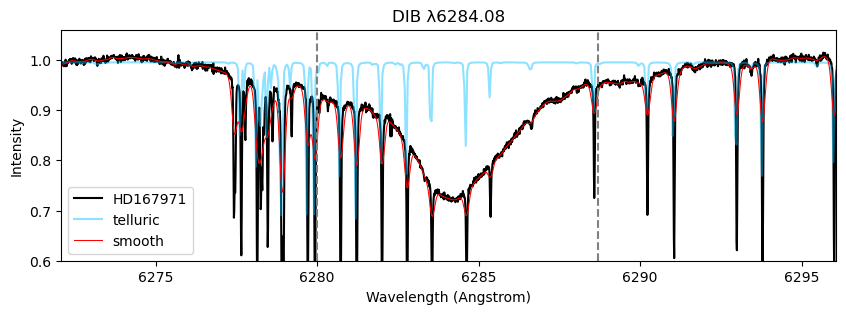

In [28]:
rv_corr = 72.42707067
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order45.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = 6280
WVend = 6288.7
ylimmin=0.6
ylimmax=1.06
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6284.08
k = -1.65
s = 0.995

DIBSanalysis(12,k,s,WVbegin,WVend,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [29]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis(n,beginning,ending,centervalue,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD167971')
    plt.plot(telluricwv_combined, telluriccont_combined+0.995, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.75,label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey', linestyle='dashed')
    plt.axvline(x=ending, color='grey', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,centervalue)
    beginningnew = velocity_doppler(beginning,centervalue)
    endingnew = velocity_doppler(ending,centervalue)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.scatter(centervalue,0.9875,color='turquoise')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', centervalue)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     5773.233917  1.007202    1.002010 -0.536916  5780.054838  5784.770603   
2     5773.243546  1.007698    1.001983 -0.183957  5796.108007  5799.927545   
3     5773.253174  1.005619    1.001921       NaN          NaN          NaN   
4     5773.262802  0.996966    1.001826       NaN          NaN          NaN   
5     5773.272431  0.996145    1.001702       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  5838.212947  0.996550    0.999652       NaN          NaN          NaN   
6713  5838.222684  1.000411    0.999704       NaN          NaN          NaN   
6714  5838.232421  0.996072    0.999744       NaN          NaN          NaN   
6715  5838.242157  0.995130    0.999772       NaN          NaN          NaN   
6716  5838.251894  1.010952    0.999786       NaN          NaN          NaN   

          FWHM       Center    Height  
1     2.120

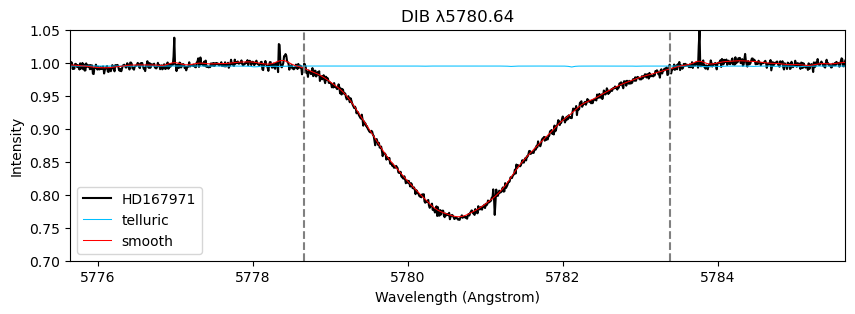

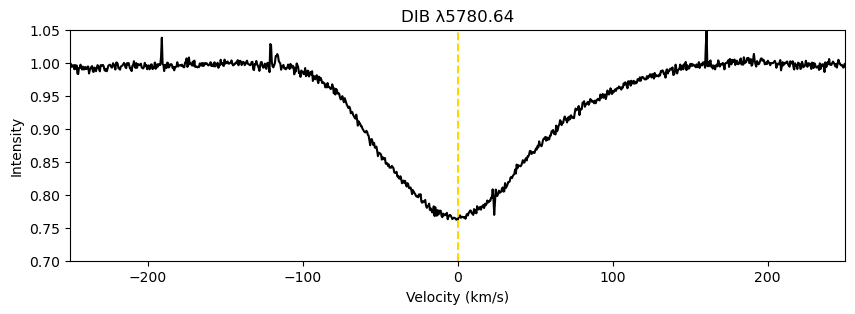

Central Wavelength :  5780.663701392811
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [30]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order38.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (5780.054838) / (rv_corr/c_kms + 1)
WVend = (5784.770603) / (rv_corr/c_kms + 1)
WVcenter = (5782.060256) / (rv_corr/c_kms + 1)
ylimmin=0.7
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 5780.64

DIBSanalysis(5,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     5773.233917  1.007202    1.002010 -0.536916  5780.054838  5784.770603   
2     5773.243546  1.007698    1.001983 -0.183957  5796.108007  5799.927545   
3     5773.253174  1.005619    1.001921       NaN          NaN          NaN   
4     5773.262802  0.996966    1.001826       NaN          NaN          NaN   
5     5773.272431  0.996145    1.001702       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  5838.212947  0.996550    0.999652       NaN          NaN          NaN   
6713  5838.222684  1.000411    0.999704       NaN          NaN          NaN   
6714  5838.232421  0.996072    0.999744       NaN          NaN          NaN   
6715  5838.242157  0.995130    0.999772       NaN          NaN          NaN   
6716  5838.251894  1.010952    0.999786       NaN          NaN          NaN   

          FWHM       Center    Height  
1     2.120

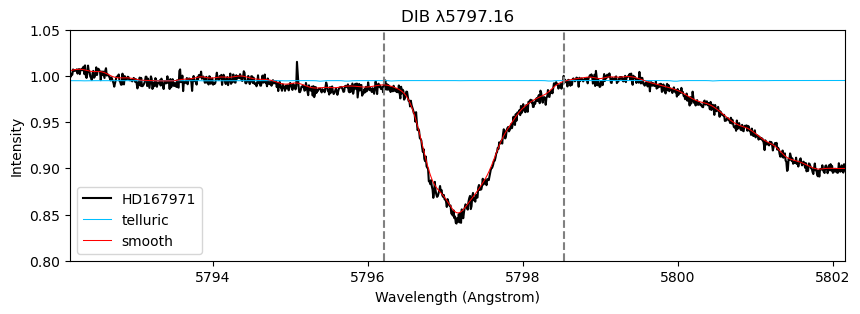

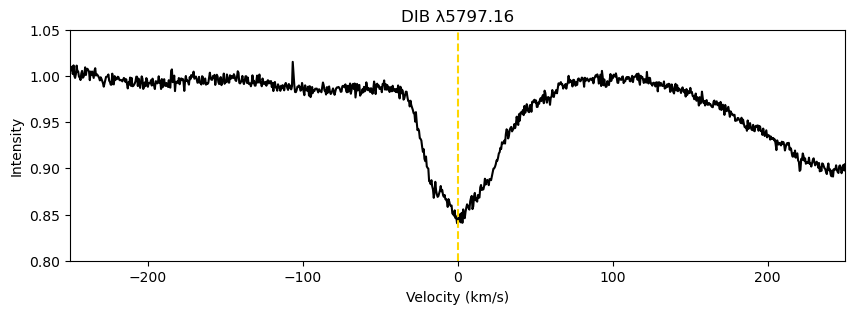

Central Wavelength :  5797.143948918227
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [31]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order38.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (5797.608007) / (rv_corr/c_kms + 1)
WVend = (5799.927545) / (rv_corr/c_kms + 1)
WVcenter = (5798.544485) / (rv_corr/c_kms + 1)
ylimmin=0.8
ylimmax=1.05
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 5797.16


DIBSanalysis(5,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6603.770015  1.004246    1.002989 -0.239767  6614.428681  6617.109829   
2     6603.781029  1.003088    1.003008       NaN          NaN          NaN   
3     6603.792042  1.001903    1.003018       NaN          NaN          NaN   
4     6603.803056  1.002285    1.003020       NaN          NaN          NaN   
5     6603.814070  1.003024    1.003013       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  6678.096913  0.985173    0.988922       NaN          NaN          NaN   
6713  6678.108051  0.984147    0.988863       NaN          NaN          NaN   
6714  6678.119188  0.986538    0.988842       NaN          NaN          NaN   
6715  6678.130326  0.989773    0.988858       NaN          NaN          NaN   
6716  6678.141463  0.987225    0.988912       NaN          NaN          NaN   

          FWHM       Center    Height  
1     1.226

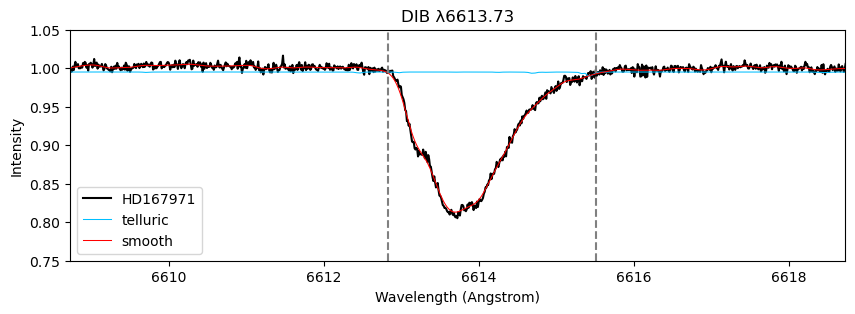

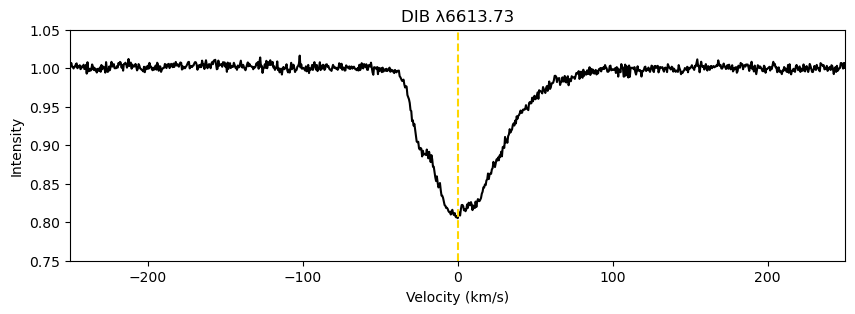

Central Wavelength :  6613.724461658131
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [32]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order50.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (6614.428681) / (rv_corr/c_kms + 1)
WVend = (6617.109829) / (rv_corr/c_kms + 1)
WVcenter = (6615.322276) / (rv_corr/c_kms + 1)
ylimmin=0.75
ylimmax=1.05
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6613.73


DIBSanalysis(5,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     4719.108646  0.998301    0.998691 -0.140364  4725.882005  4731.094647   
2     4719.116516  1.001068    0.998710 -0.094583  4761.363732  4765.915998   
3     4719.124386  1.000514    0.998732       NaN          NaN          NaN   
4     4719.132257  0.990359    0.998755       NaN          NaN          NaN   
5     4719.140127  0.992982    0.998782       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  4772.223261  1.006466    1.002699       NaN          NaN          NaN   
6713  4772.231220  0.992667    1.002687       NaN          NaN          NaN   
6714  4772.239179  1.007774    1.002671       NaN          NaN          NaN   
6715  4772.247138  0.997149    1.002653       NaN          NaN          NaN   
6716  4772.255097  0.995933    1.002636       NaN          NaN          NaN   

          FWHM       Center    Height  
1     1.162

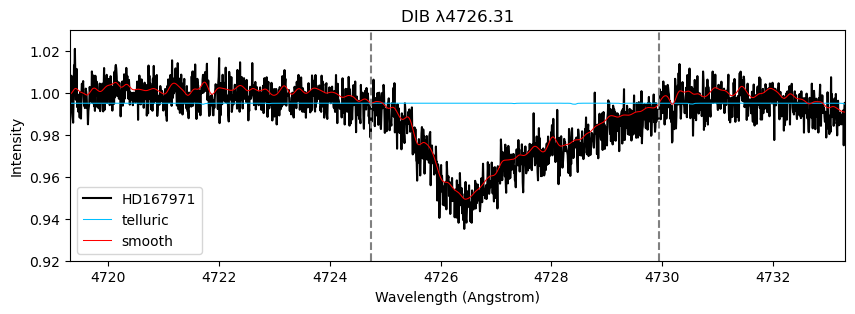

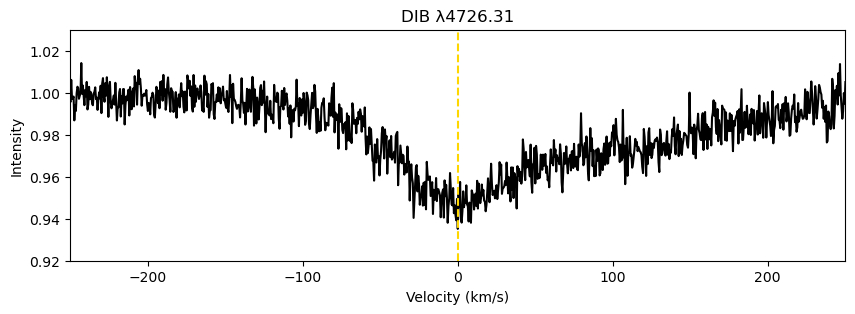

Central Wavelength :  4726.427117150284
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [34]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order20.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (4725.882005) / (rv_corr/c_kms + 1)
WVend = (4731.094647) / (rv_corr/c_kms + 1)
WVcenter = (4727.568978) / (rv_corr/c_kms + 1)
ylimmin=0.92
ylimmax=1.03
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 4726.31



DIBSanalysis(7,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6174.553347  1.002052    0.999329 -0.060083  6197.043165  6198.242164   
2     6174.563645  0.993462    0.999360 -0.261158  6202.605995  6209.426751   
3     6174.573942  0.995382    0.999426       NaN          NaN          NaN   
4     6174.584240  0.997398    0.999524       NaN          NaN          NaN   
5     6174.594538  1.000011    0.999648       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  6244.049316  0.997701    0.999150       NaN          NaN          NaN   
6713  6244.059730  1.001134    0.999157       NaN          NaN          NaN   
6714  6244.070143  0.992307    0.999157       NaN          NaN          NaN   
6715  6244.080557  0.996160    0.999153       NaN          NaN          NaN   
6716  6244.090971  0.998782    0.999147       NaN          NaN          NaN   

          FWHM       Center    Height  
1     0.781

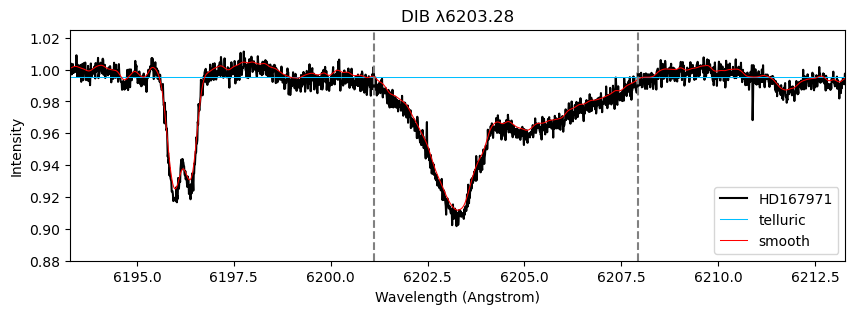

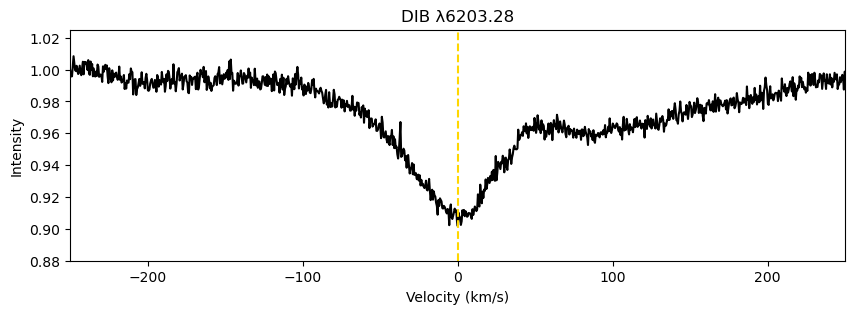

Central Wavelength :  6203.249023707734
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [37]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order44.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (6202.605995) / (rv_corr/c_kms + 1)
WVend = (6209.426751) / (rv_corr/c_kms + 1)
WVcenter = (6204.747671) / (rv_corr/c_kms + 1)
ylimmin=0.88
ylimmax=1.025
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6203.28



DIBSanalysis(10,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [47]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysistriplets(n1,n2,m,s,beginning1,beginning2, beginning3, ending1, ending2, ending3,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral1,restcentral2,restcentral3):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD167971')
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.75,label='smooth')
#     plt.plot(telluricwv_combined+m, telluriccont_combined+s, c='deepskyblue', label='telluric',linestyle = 'dashed')
    plt.axvline(x=beginning1, color='green', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral1}')
    plt.axvline(x=beginning2, color='purple', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral2}')
    plt.axvline(x=beginning3, color='brown', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral3}')
    plt.axvline(x=ending1, color='green', linestyle='dashed',linewidth=0.9)
    plt.axvline(x=ending2, color='purple', linestyle='dashed',linewidth=0.9)
    plt.axvline(x=ending3, color='brown', linestyle='dashed',linewidth=0.9)
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'Triplets DIB λ{restcentral1}, λ{restcentral2}, & λ{restcentral3}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral1-n1,restcentral3+n2)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

#     v = velocity_doppler(WV,centervalue)
#     beginningnew = velocity_doppler(beginning,centervalue)
#     endingnew = velocity_doppler(ending,centervalue)
#     plt.figure(figsize=(10,3))
#     plt.plot(v,FLUX,c='black')
# #     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
# #     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
# #     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
#     plt.scatter(centervalue,0.9875,color='turquoise')
#     plt.xlabel('Velocity (km/s)')
#     plt.ylabel('Intensity')
#     plt.title(f'DIB λ{restcentral}')
#     plt.xlim(-xlimvel,xlimvel)
#     plt.ylim(ylimmin,ylimmax)
#     plt.show()
    

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6385.556378  1.001100    1.001923 -0.025979  6439.284697  6442.711413   
2     6385.567027  0.996773    1.001887 -0.029860  6445.387451  6448.709864   
3     6385.577677  1.005501    1.001831 -0.020228  6449.032520  6452.141595   
4     6385.588326  1.000534    1.001756       NaN          NaN          NaN   
5     6385.598976  1.002607    1.001664       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
6712  6457.427233  0.977024    0.984408       NaN          NaN          NaN   
6713  6457.438002  0.979212    0.984245       NaN          NaN          NaN   
6714  6457.448772  0.972999    0.984109       NaN          NaN          NaN   
6715  6457.459541  0.979158    0.984013       NaN          NaN          NaN   
6716  6457.470311  0.982599    0.983964       NaN          NaN          NaN   

          FWHM       Center    Height  
1     0.357

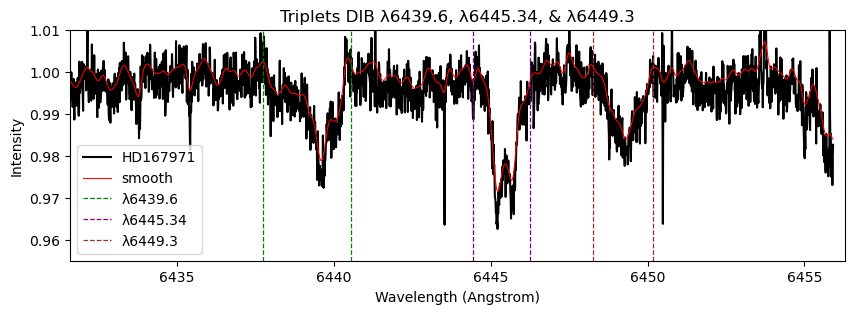

In [53]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order47.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
beginning1 = (6439.284697) / (rv_corr/c_kms + 1)
ending1 = (6442.111413) / (rv_corr/c_kms + 1)
restcentral1 = 6439.60
beginning2 = (6445.987451) / (rv_corr/c_kms + 1)
ending2 = (6447.809864) / (rv_corr/c_kms + 1)
restcentral2 = 6445.34
beginning3 = (6449.832520) / (rv_corr/c_kms + 1)
ending3 = (6451.741595) / (rv_corr/c_kms + 1)
restcentral3 = 6449.30

ylimmin=0.955
ylimmax=1.01
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
n1 = 8
n2 = 7
m = 0.4
s = 0.995

DIBSanalysistriplets(n1,n2,m,s,beginning1,beginning2, beginning3, ending1, ending2, ending3,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral1,restcentral2,restcentral3)

In [102]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def moleculeanalysis(l,n,m,beginning,ending,centervalue,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD167971')
    plt.plot(telluricwv_combined+m, telluriccont_combined+0.995, c='deepskyblue', label='telluric')
    plt.plot(WV,FLUXSMOOTH,c='red',label='smooth',linewidth=0.5)
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey')
    plt.axvline(x=ending, color='grey')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'K I : λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-l,restcentral+n)
#     plt.xlim(7600,7900)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,centervalue)
    beginningnew = velocity_doppler(beginning,centervalue)
    endingnew = velocity_doppler(ending,centervalue)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='grey', linestyle='dashed', label=f'λ{restcentral}')
    plt.scatter(centervalue,0.9875,color='turquoise')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', centervalue)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth
1     7638.870092  0.397879    0.240192
2     7638.882832  0.370527    0.237200
3     7638.895572  0.337947    0.231321
4     7638.908312  0.302436    0.222769
5     7638.921051  0.271744    0.211852
...           ...       ...         ...
6712  7724.847271  1.012619    1.011906
6713  7724.860154  1.015198    1.012125
6714  7724.873038  1.015423    1.012294
6715  7724.885921  1.011209    1.012413
6716  7724.898804  1.014359    1.012484

[6716 rows x 3 columns]


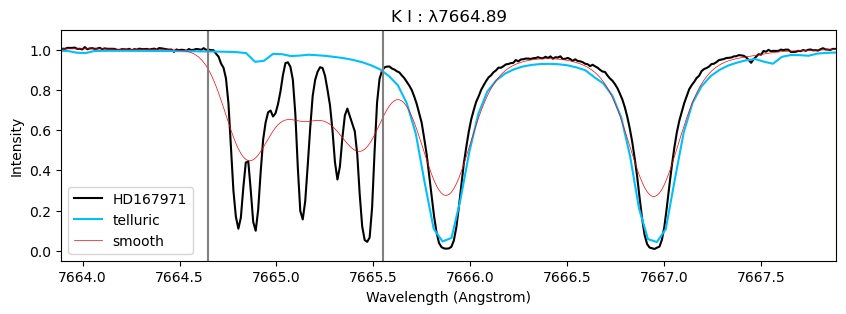

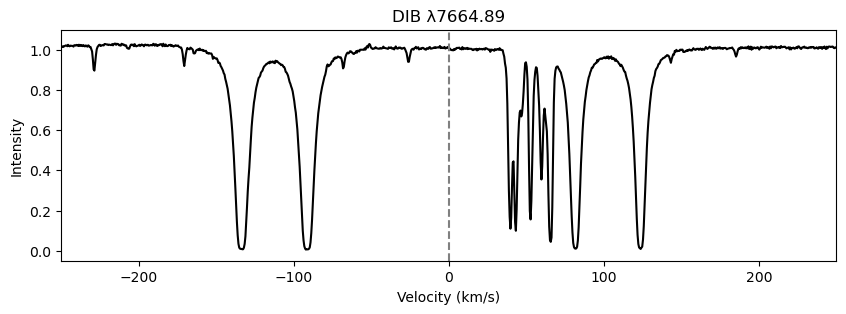

Central Wavelength :  7663.788499948969
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [134]:

c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order63.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (7666.5) / (rv_corr/c_kms + 1)
WVend = (7667.4) / (rv_corr/c_kms + 1)
WVcenter = (7665.64) / (rv_corr/c_kms + 1)
ylimmin=-0.05
ylimmax=1.1
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 7664.89

n=3
l = 1
m= 0.45

moleculeanalysis(l,n,m,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth
1     7638.870092  0.397879    0.240192
2     7638.882832  0.370527    0.237200
3     7638.895572  0.337947    0.231321
4     7638.908312  0.302436    0.222769
5     7638.921051  0.271744    0.211852
...           ...       ...         ...
6712  7724.847271  1.012619    1.011906
6713  7724.860154  1.015198    1.012125
6714  7724.873038  1.015423    1.012294
6715  7724.885921  1.011209    1.012413
6716  7724.898804  1.014359    1.012484

[6716 rows x 3 columns]


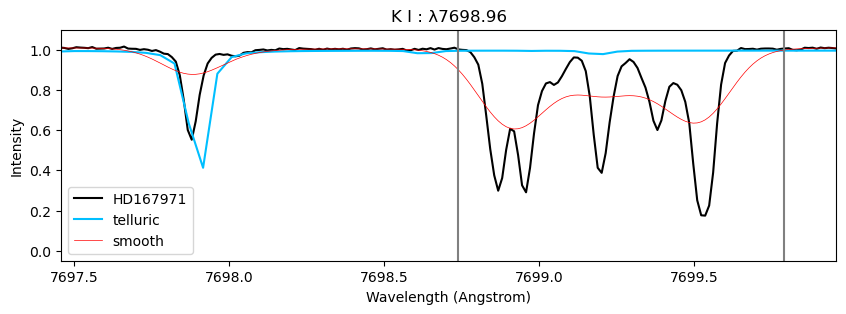

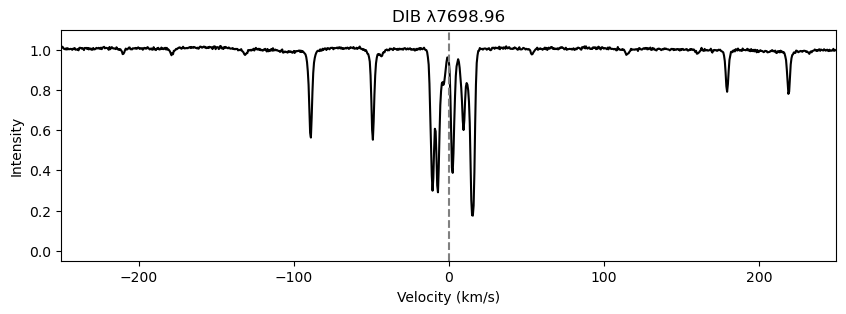

Central Wavelength :  7699.139959365038
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [137]:
rv_corr = 72.42707067
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order63.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (7700.6) / (rv_corr/c_kms + 1)
WVend = (7701.65) / (rv_corr/c_kms + 1)
WVcenter = (7701) / (rv_corr/c_kms + 1)
ylimmin=-0.05
ylimmax=1.1
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 7698.96

n=1
l = 1.5
m= 1.45

moleculeanalysis(l,n,m,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [143]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis(h,n,m,beginning,ending,centervalue,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD167971',alpha=0.3)
    plt.plot(telluricwv_combined+h, telluriccont_combined+m, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.plot(WV,FLUXSMOOTH,c='red',label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='indigo', linestyle='dashed')
    plt.axvline(x=ending, color='indigo', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,centervalue)
    beginningnew = velocity_doppler(beginning,centervalue)
    endingnew = velocity_doppler(ending,centervalue)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.scatter(centervalue,0.9875,color='turquoise')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', centervalue)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth
1     6037.772564  1.003907    1.001762
2     6037.782633  0.999402    1.001732
3     6037.792703  1.002683    1.001679
4     6037.802773  1.001759    1.001605
5     6037.812842  0.999477    1.001512
...           ...       ...         ...
6712  6105.729035  0.994202    1.000358
6713  6105.739218  0.998203    1.000423
6714  6105.749401  0.996313    1.000475
6715  6105.759584  0.993594    1.000514
6716  6105.769767  1.007642    1.000538

[6716 rows x 3 columns]


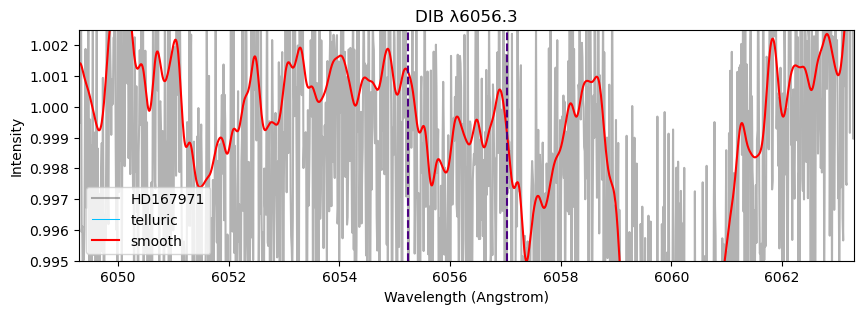

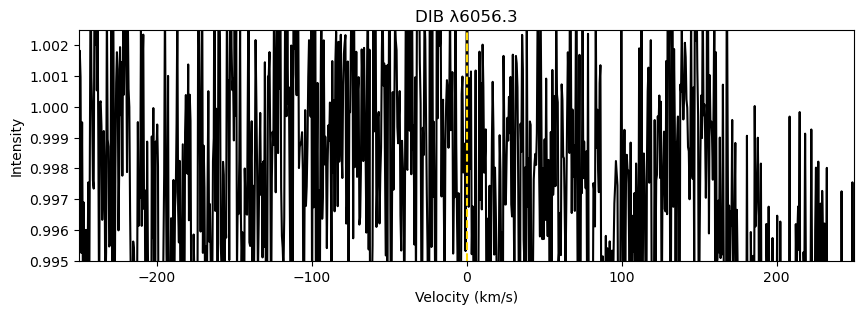

Central Wavelength :  6055.537038550063
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [144]:
rv_corr = 72.42707067
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order42.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (6056.7) / (rv_corr/c_kms + 1)
WVend = (6058.5) / (rv_corr/c_kms + 1)
WVcenter = (6057) / (rv_corr/c_kms + 1)
ylimmin=0.995
ylimmax=1.0025
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6056.30

n=7
m=0.0036
h=0

DIBSanalysis(h,n,m,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth
1     7062.823166  0.980498    0.982904
2     7062.834945  0.974916    0.982823
3     7062.846724  0.977507    0.982691
4     7062.858503  0.977888    0.982504
5     7062.870282  0.983660    0.982255
...           ...       ...         ...
6712  7142.316809  0.996897    1.001632
6713  7142.328720  1.000677    1.001814
6714  7142.340632  1.003099    1.001960
6715  7142.352544  1.003424    1.002065
6716  7142.364456  1.004112    1.002125

[6716 rows x 3 columns]


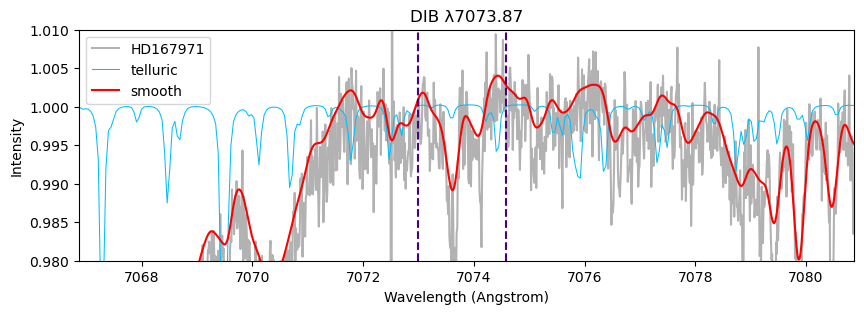

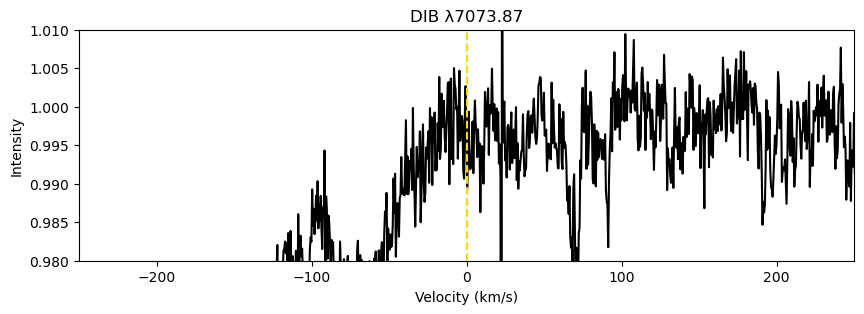

Central Wavelength :  7071.982253803073
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [235]:
rv_corr = 43.14386307078081
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/167971/trim167971order56.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV_f = (df['WV']) / (rv_corr/c_kms + 1)
WVbegin = (7074) / (rv_corr/c_kms + 1)
WVend = (7075.6) / (rv_corr/c_kms + 1)
WVcenter = (7073) / (rv_corr/c_kms + 1)
ylimmin=0.98
ylimmax=1.01
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 7073.87

n=7
m=0.0036
h = 0.05

DIBSanalysis(h,n,m,WVbegin,WVend,WVcenter,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [ ]:
#DIB 186745

Telluric part 0


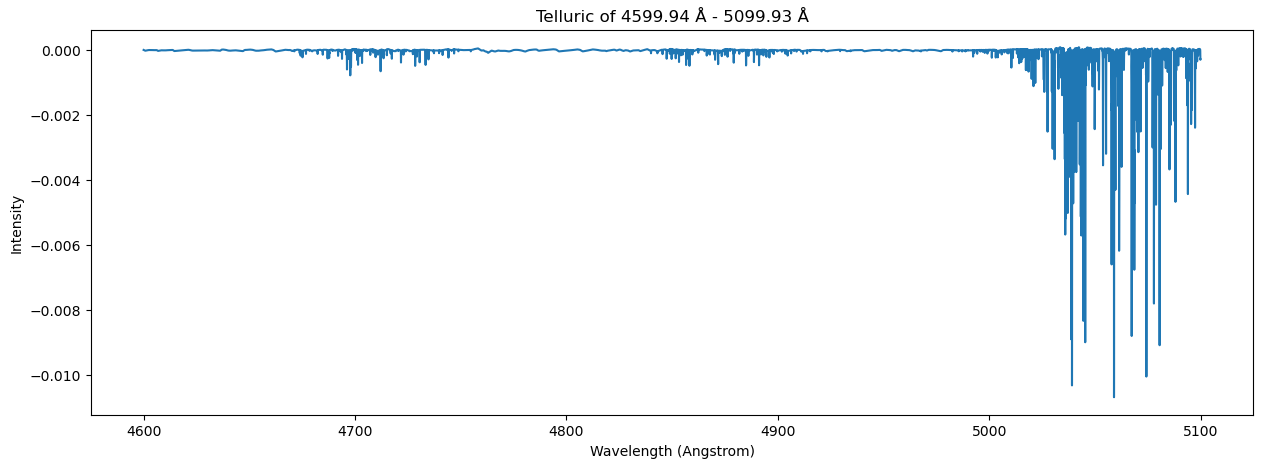

Telluric part 1


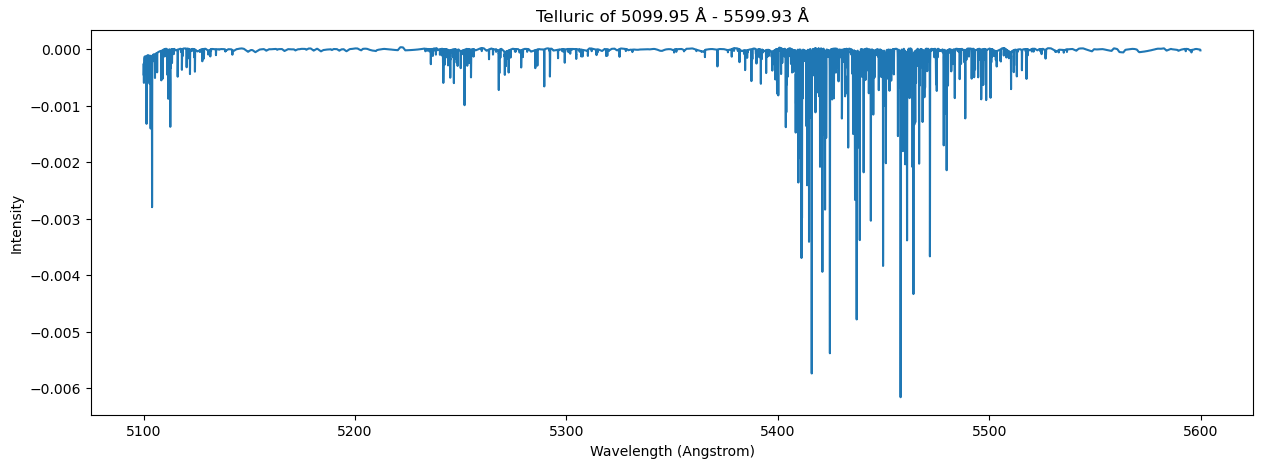

Telluric part 2


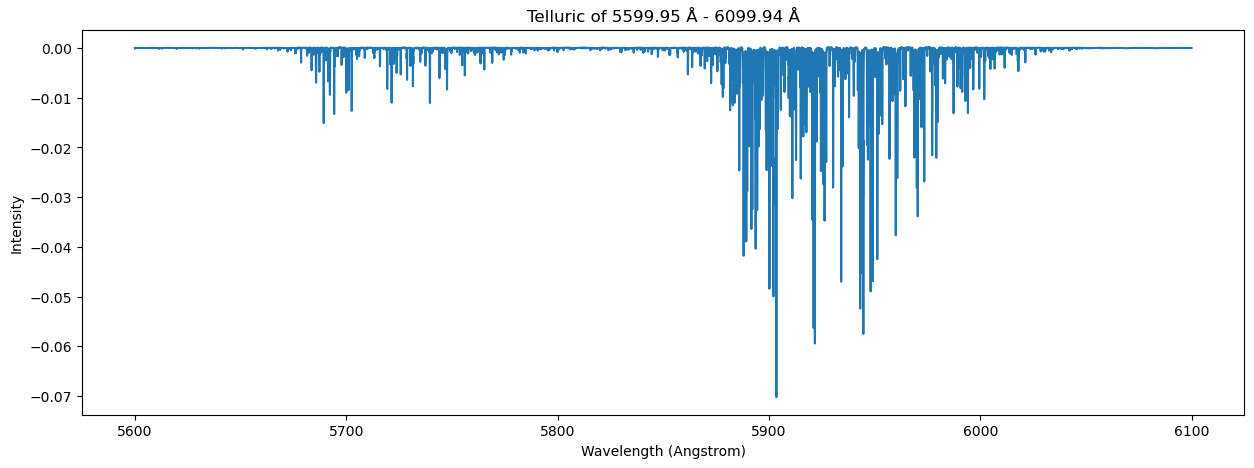

Telluric part 3


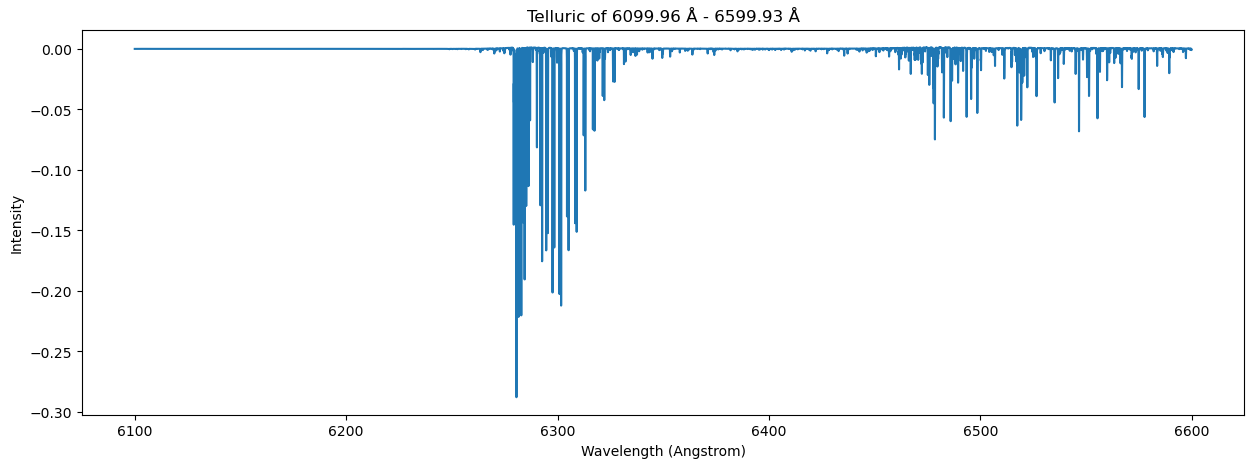

Telluric part 4


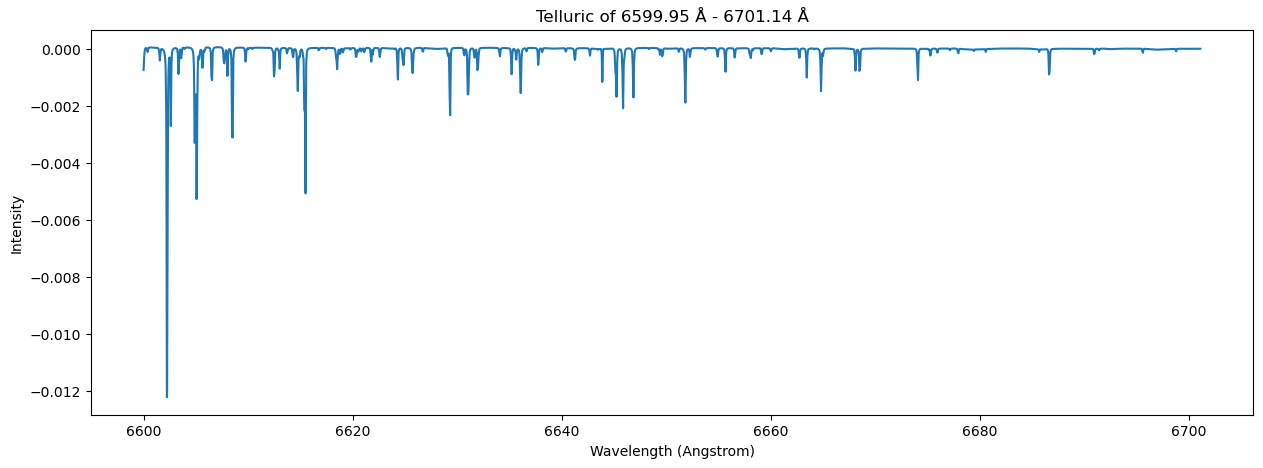

Combining all continuum telluric


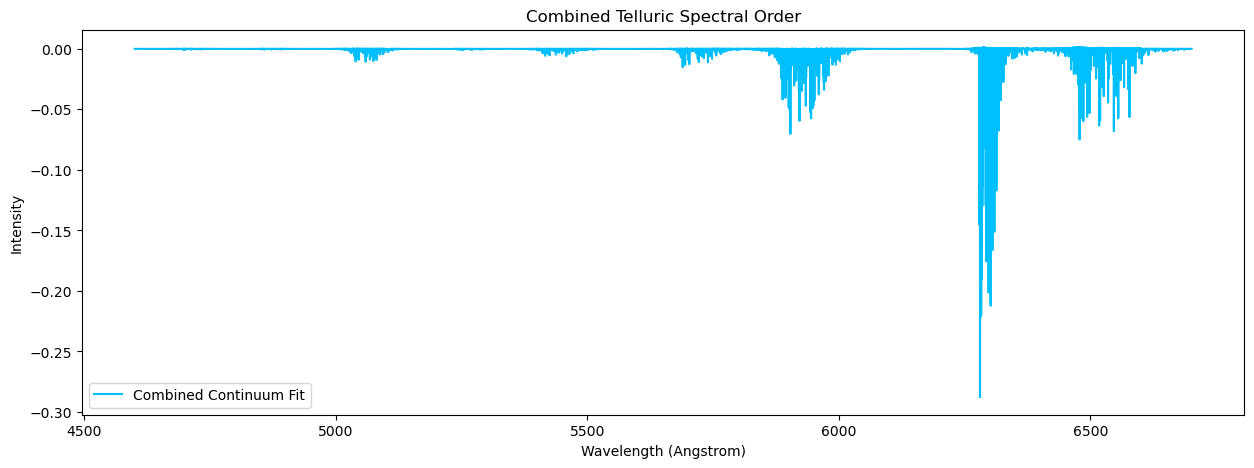

Combining all continuum telluric scaled


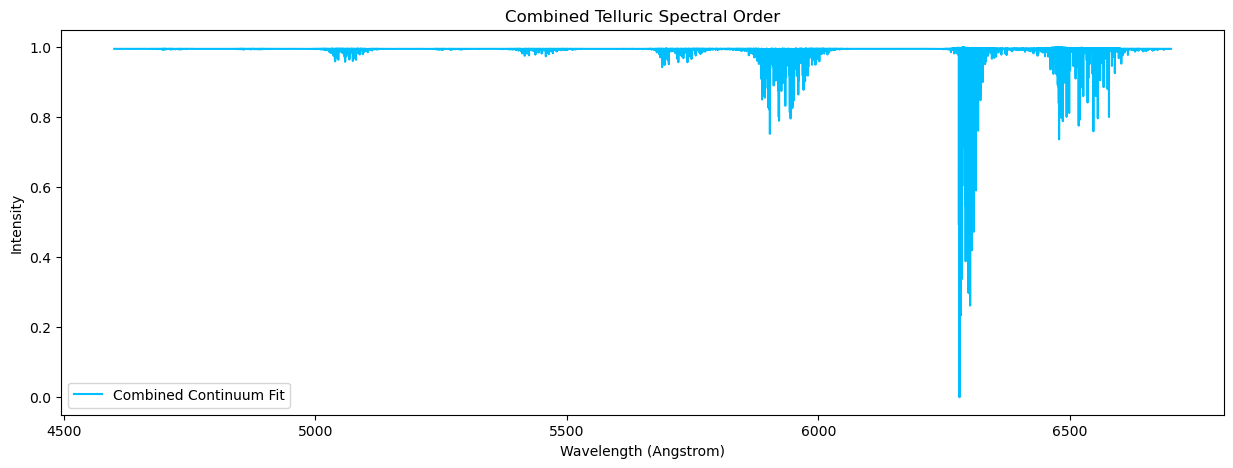

In [3]:
def normalize_data(data, min_value=0, max_value=1):
    scaler = MinMaxScaler(feature_range=(min_value, max_value))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaled_data.flatten()

continuum_trans = []
wv_telluric = []

# Read and process data, plot fitting and continuum spectral order, and save each DataFrame to CSV
for i in range(1,6):    
    # Read data
    df = pd.read_csv(f'./telluric/telluricsplitorder-1-{i}.csv')
    df = df.drop(df.index[0]) # remove unused string row
    df['Subtracted_Data Y1'] = pd.to_numeric(df['Subtracted_Data Y1']) # convert string to numeric
    df['tellurictrans'] = df['Subtracted_Data Y1'] # normalized flux
    
    df['telluricwv'] = df['Unnamed: 0'] # wavelength in angstrom
    
    wv_telluric.append(df['telluricwv'])
    continuum_trans.append(df['tellurictrans'])
    
    print(f'Telluric part {i-1}')
    
    # Plot continuum telluric 
    plt.figure(figsize=(15,5))
    plt.plot(df['telluricwv'],df['tellurictrans'])
    plt.title(f"Telluric of {df['telluricwv'].min():.2f} Å - {df['telluricwv'].max():.2f} Å")
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.show()
    
# Concatenate data and plot combined continuum spectral order
telluricwv_combined1 = np.concatenate(wv_telluric)
telluriccont_combined1 = np.concatenate(continuum_trans)
print('Combining all continuum telluric')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined1, telluriccont_combined1, c='deepskyblue',label='Combined Continuum Fit')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

telluriccont_combined1 = normalize_data(telluriccont_combined1, min_value=0, max_value=1)

print('Combining all continuum telluric scaled')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined1, telluriccont_combined1, c='deepskyblue',label='Combined Continuum Fit')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

np.savetxt('telluric1_186745.txt', np.column_stack((telluricwv_combined1, telluriccont_combined1)), delimiter=' ', header='wv flux', comments='')


Telluric part 0


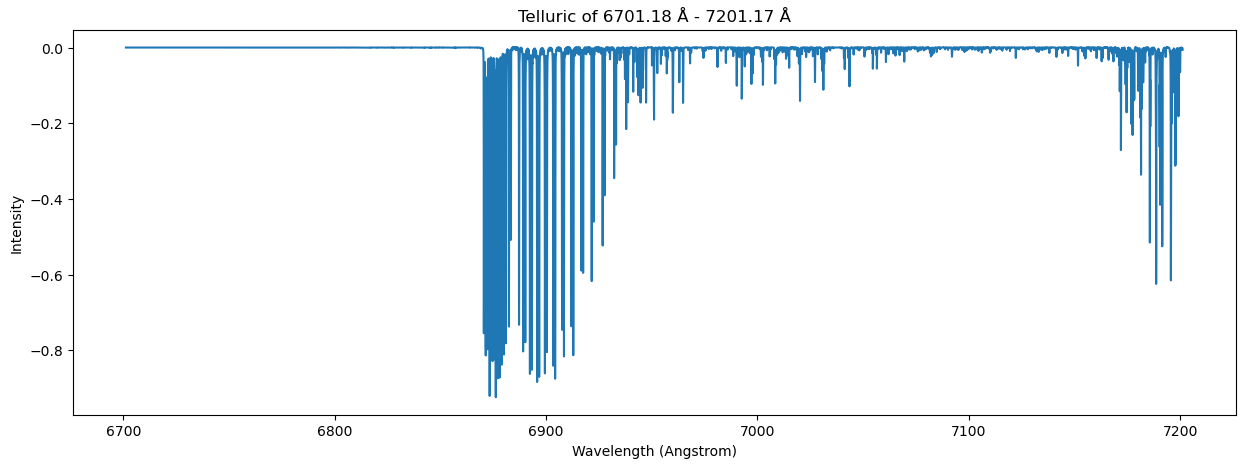

Telluric part 1


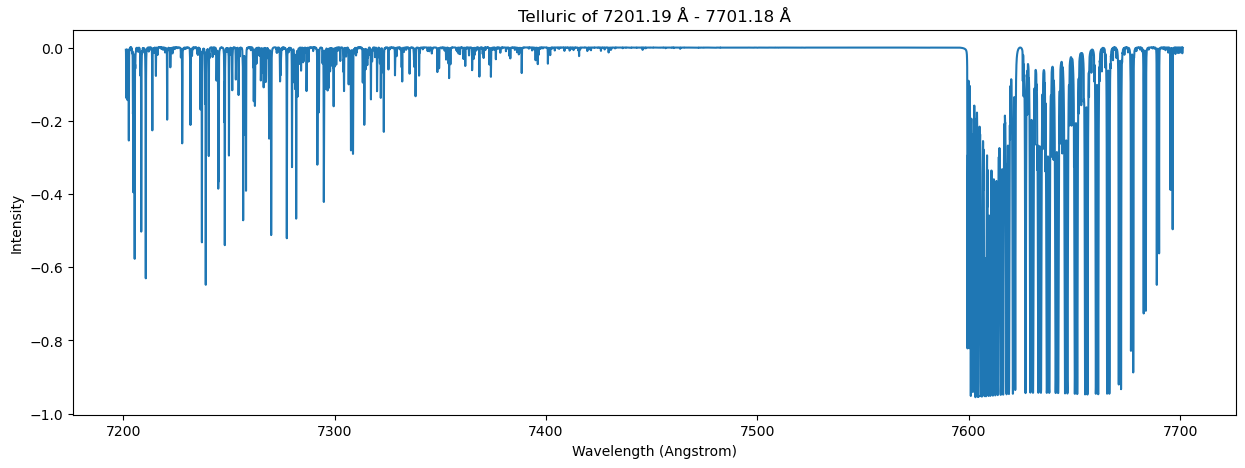

Telluric part 2


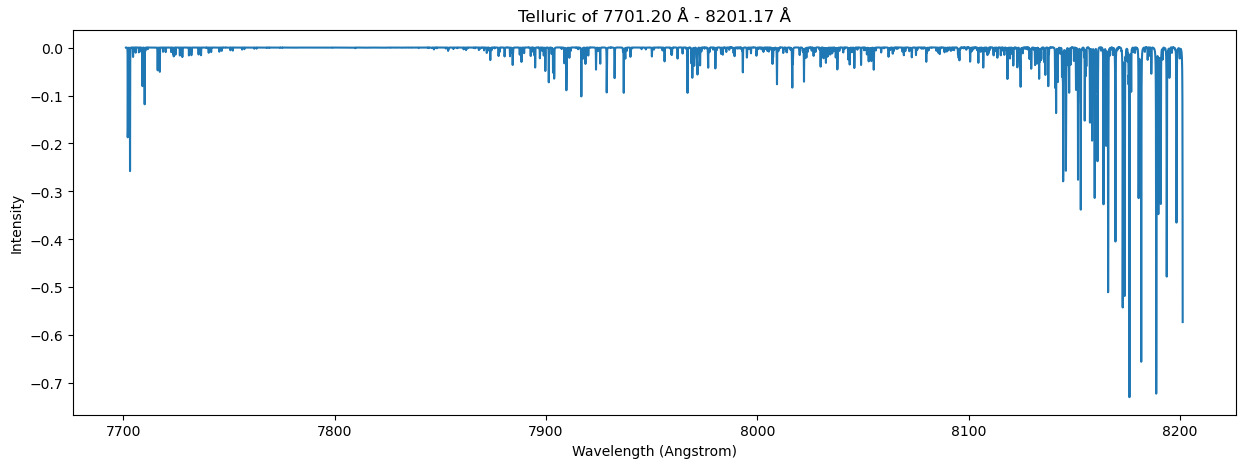

Telluric part 3


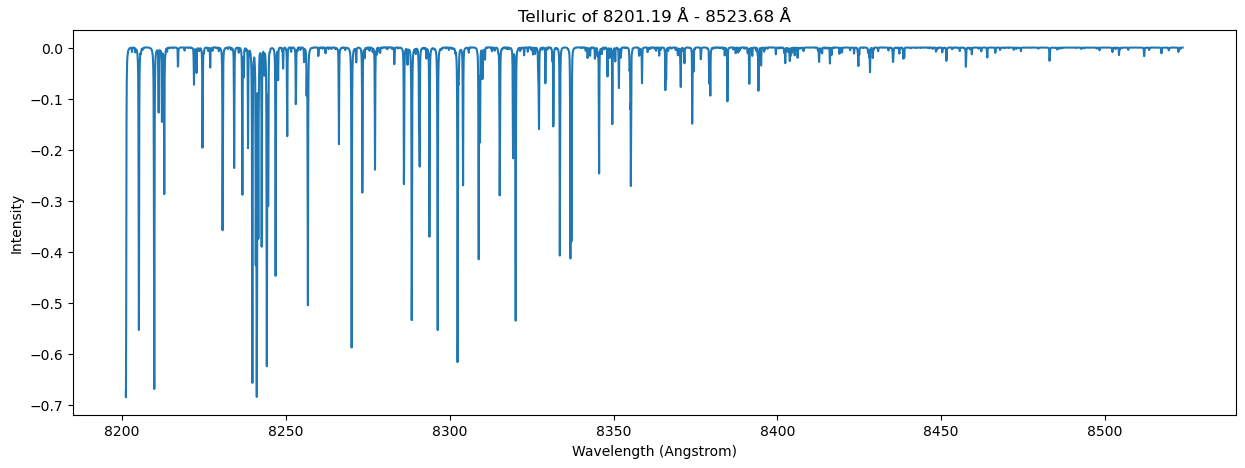

Combining all continuum telluric


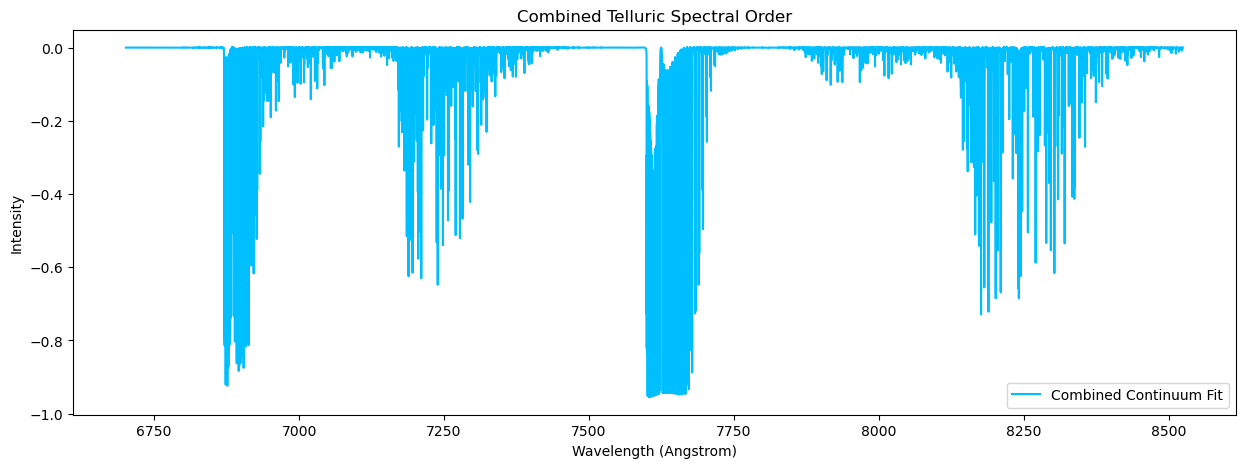

Combining all continuum telluric scaled


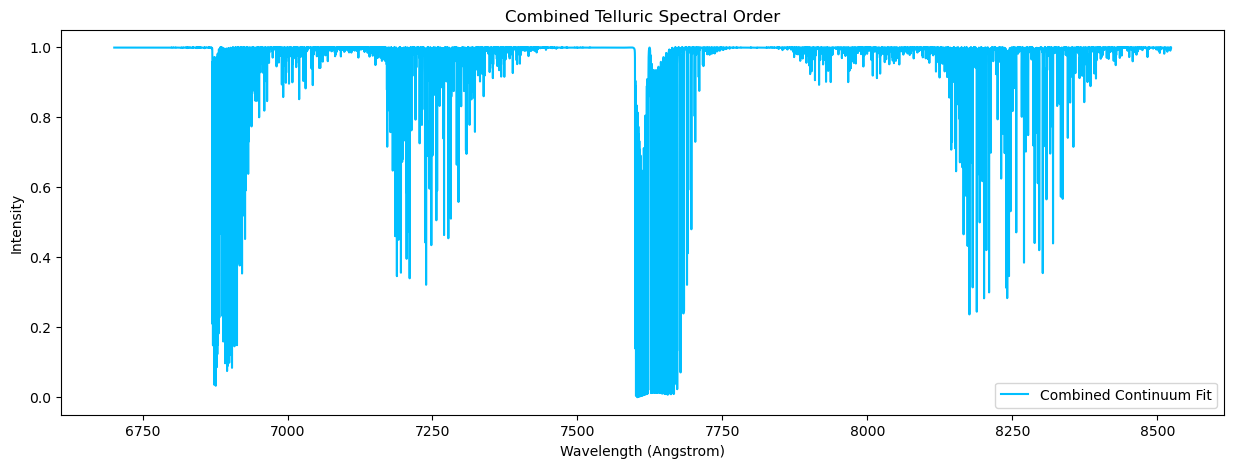

In [4]:
def normalize_data(data, min_value=0, max_value=1):
    scaler = MinMaxScaler(feature_range=(min_value, max_value))
    scaled_data = scaler.fit_transform(data.reshape(-1, 1))
    return scaled_data.flatten()

continuum_trans = []
wv_telluric = []

# Read and process data, plot fitting and continuum spectral order, and save each DataFrame to CSV
for i in range(1,5):    
    # Read data
    df = pd.read_csv(f'./telluric/telluricsplitorder-2-{i}.csv')
    df = df.drop(df.index[0]) # remove unused string row
    df['Subtracted_Data Y1'] = pd.to_numeric(df['Subtracted_Data Y1']) # convert string to numeric
    df['tellurictrans'] = df['Subtracted_Data Y1'] # normalized flux
    
    df['telluricwv'] = df['Unnamed: 0'] # wavelength in angstrom
    
    wv_telluric.append(df['telluricwv'])
    continuum_trans.append(df['tellurictrans'])
    
    print(f'Telluric part {i-1}')
    
    # Plot continuum telluric 
    plt.figure(figsize=(15,5))
    plt.plot(df['telluricwv'],df['tellurictrans'])
    plt.title(f"Telluric of {df['telluricwv'].min():.2f} Å - {df['telluricwv'].max():.2f} Å")
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.show()
    
# Concatenate data and plot combined continuum spectral order
telluricwv_combined2 = np.concatenate(wv_telluric)
telluriccont_combined2 = np.concatenate(continuum_trans)
print('Combining all continuum telluric')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined2, telluriccont_combined2, c='deepskyblue',label='Combined Continuum Fit')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

telluriccont_combined2 = normalize_data(telluriccont_combined2, min_value=0, max_value=1)

print('Combining all continuum telluric scaled')
plt.figure(figsize=(15, 5))
plt.plot(telluricwv_combined2, telluriccont_combined2, c='deepskyblue',label='Combined Continuum Fit')
plt.title("Combined Telluric Spectral Order")
plt.xlabel("Wavelength (Angstrom)")
plt.ylabel("Intensity")
plt.legend()
plt.show()

np.savetxt('telluric2_186745.txt', np.column_stack((telluricwv_combined2, telluriccont_combined2)), delimiter=' ', header='wv flux', comments='')


In [5]:
# Open the FITS file
hdul = fits.open('./model/ADP.2016-09-22T12_25_23.641.fits') #BetOri FEROS 398.9 SNR
# print(hdul[1].header)

wv = hdul[1].data['WAVE']
flux = hdul[1].data['FLUX']
wvflatten  = wv.flatten()
fluxflatten = flux.flatten()
print(wvflatten)
print(fluxflatten)
print(wv.shape)
print(flux.shape)
print(np.mean(flux))
print(type(wv))
print(type(flux))

stellarwv = wvflatten
stellarflux = fluxflatten


[3527.27999997 3527.30999997 3527.33999997 ... 9216.02987281 9216.05987281
 9216.08987281]
[0.         0.         0.         ... 0.4712234  0.4653195  0.45878482]
(1, 189628)
(1, 189628)
0.6536266
<class 'numpy.ndarray'>
<class 'numpy.ndarray'>


In [6]:

def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD186745')
    plt.plot(telluricwv+m, telluricflux+0.003, c='deepskyblue', label='telluric',alpha=0.45)
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.5,label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey', linestyle='dashed')
    plt.axvline(x=ending, color='grey', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,restcentral)
    beginningnew = velocity_doppler(beginning,restcentral)
    endingnew = velocity_doppler(ending,restcentral)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', restcentral)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth
1     6246.372781  1.011986    1.005928
2     6246.389299  1.008317    1.005590
3     6246.405816  1.006372    1.005035
4     6246.422334  1.002827    1.004437
5     6246.438852  1.004605    1.003961
...           ...       ...         ...
4086  6313.847654  1.005708    1.000182
4087  6313.864171  1.008238    1.000154
4088  6313.880689  1.009011    0.999893
4089  6313.897207  1.001805    0.999538
4090  6313.913725  0.992608    0.999282

[4090 rows x 3 columns]


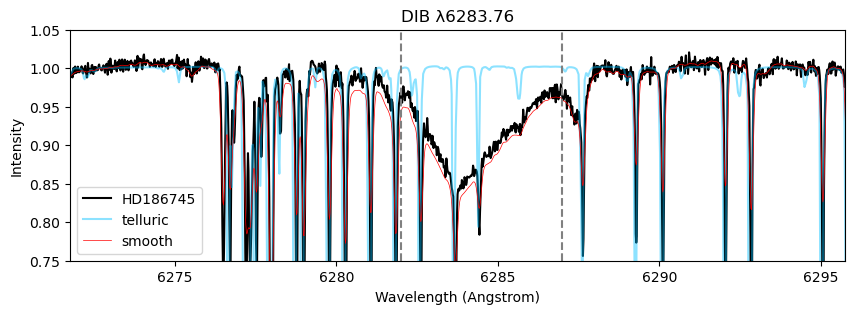

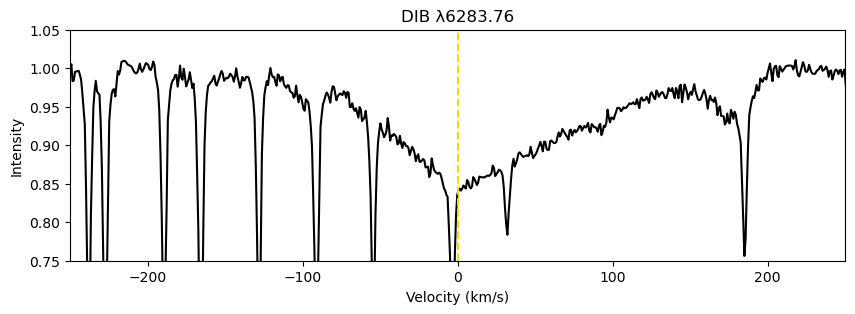

Central Wavelength :  6283.76
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [11]:
rv_corr = -13.2893505248607
rv_corr1 = 18.72979623
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order53.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV']/ (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = 6282
ending = 6287
ylimmin=0.75
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6283.76
n = 12
m =  -2.6
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [37]:
# # Open the FITS file
# hdul1 = fits.open('./data/ADP.2020-06-10T09_10_02.251.fits')
# # print(hdul[1].header)

# wv1 = hdul1[1].data['WAVE']
# flux1 = hdul1[1].data['FLUX']/(1*10**(4))

# # Open the FITS file
# hdul2 = fits.open('./data/ADP.2020-06-10T09_10_02.301.fits')
# # print(hdul[1].header)

# wv2 = hdul2[1].data['WAVE']
# flux2 = hdul2[1].data['FLUX']/(1*10**(4))

# print(wv1)
# print(flux1)
# print(np.mean(flux1))

# print(wv2)
# print(flux2)
# print(np.mean(flux2))

In [12]:

def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD186745')
    plt.plot(telluricwv+m, telluricflux+0.003, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.5,label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey', linestyle='dashed')
    plt.axvline(x=ending, color='grey', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,restcentral)
    beginningnew = velocity_doppler(beginning,restcentral)
    endingnew = velocity_doppler(ending,restcentral)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', restcentral)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     5773.470552  1.001788    1.000104 -0.482889  5778.458902  5783.067345   
2     5773.487070  0.999674    1.000011 -0.266374  5794.679300  5799.139084   
3     5773.503587  0.997525    0.999815 -0.017902  5800.064076  5802.640840   
4     5773.520105  0.998437    0.999561       NaN          NaN          NaN   
5     5773.536623  1.000692    0.999297       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
2041  5807.166694  0.980488    0.979482       NaN          NaN          NaN   
2042  5807.183212  0.985512    0.979608       NaN          NaN          NaN   
2043  5807.199729  0.986364    0.979670       NaN          NaN          NaN   
2044  5807.216247  0.974761    0.979653       NaN          NaN          NaN   
2045  5807.232765  0.974067    0.979607       NaN          NaN          NaN   

          FWHM       Center    Height  
1     1.952

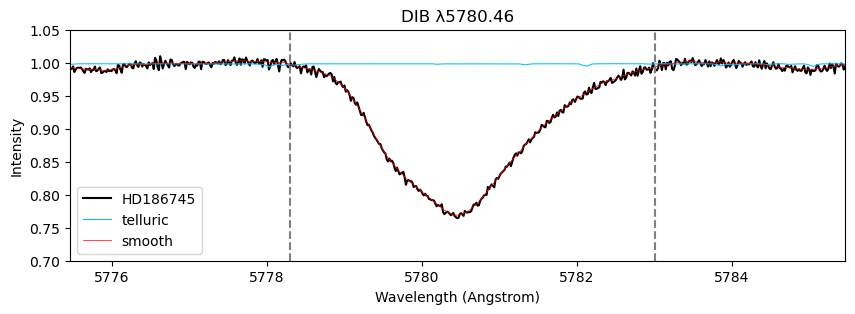

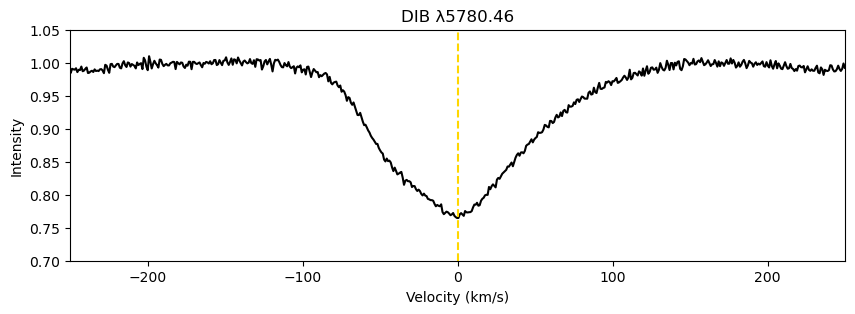

Central Wavelength :  5780.46
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [16]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order39.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV']/(rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = 5778.3
ending = 5783
ylimmin=0.7
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 5780.46
n = 5
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     5773.470552  1.001788    1.000104 -0.482889  5778.458902  5783.067345   
2     5773.487070  0.999674    1.000011 -0.266374  5794.679300  5799.139084   
3     5773.503587  0.997525    0.999815 -0.017902  5800.064076  5802.640840   
4     5773.520105  0.998437    0.999561       NaN          NaN          NaN   
5     5773.536623  1.000692    0.999297       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
2041  5807.166694  0.980488    0.979482       NaN          NaN          NaN   
2042  5807.183212  0.985512    0.979608       NaN          NaN          NaN   
2043  5807.199729  0.986364    0.979670       NaN          NaN          NaN   
2044  5807.216247  0.974761    0.979653       NaN          NaN          NaN   
2045  5807.232765  0.974067    0.979607       NaN          NaN          NaN   

          FWHM       Center    Height  
1     1.952

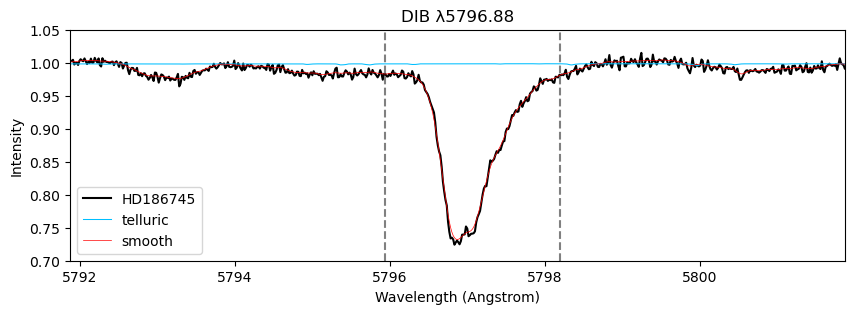

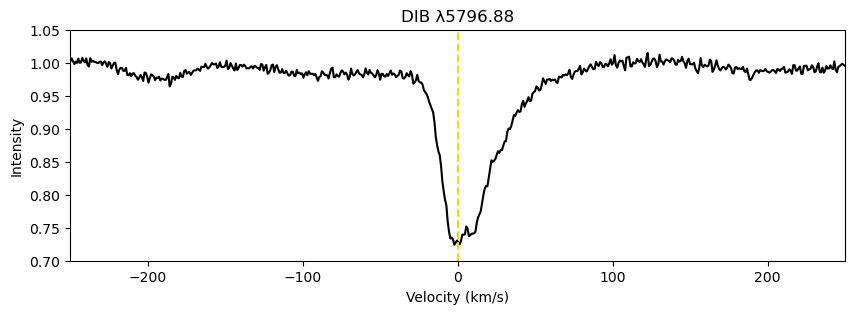

Central Wavelength :  5796.88
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [17]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order39.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV'] / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = (5795.679300) / (rv_corr/c_kms + 1)
ending = 5798.2
ylimmin=0.7
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 5796.88
n = 5
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6584.160087  0.943495    0.951857 -0.293669  6612.686184  6615.196877   
2     6584.176605  0.948411    0.952384       NaN          NaN          NaN   
3     6584.193123  0.948184    0.953347       NaN          NaN          NaN   
4     6584.209641  0.948925    0.954651       NaN          NaN          NaN   
5     6584.226158  0.951625    0.956168       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
2041  6617.856229  0.997631    0.999085       NaN          NaN          NaN   
2042  6617.872747  0.989738    0.999267       NaN          NaN          NaN   
2043  6617.889265  0.990730    0.999539       NaN          NaN          NaN   
2044  6617.905783  1.002570    0.999819       NaN          NaN          NaN   
2045  6617.922300  1.001768    0.999989       NaN          NaN          NaN   

          FWHM       Center    Height  
1     0.948

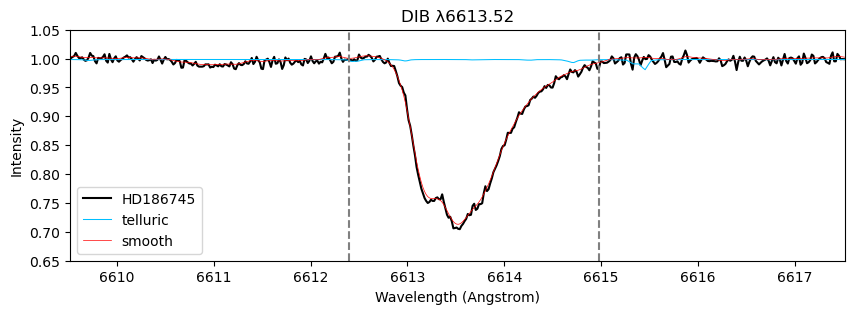

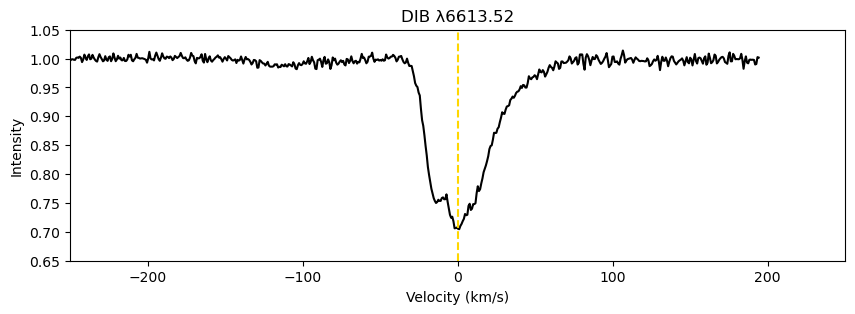

Central Wavelength :  6613.52
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [31]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order63.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV'] / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = 6612.4
ending = 6614.98
ylimmin=0.65
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6613.52
n = 4
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6178.815320  1.003483    1.002061 -0.072016  6195.630355  6197.397751   
2     6178.831837  0.998997    1.001948 -0.194670  6201.246379  6207.787395   
3     6178.848355  0.998883    1.001809       NaN          NaN          NaN   
4     6178.864873  0.998043    1.001716       NaN          NaN          NaN   
5     6178.881391  0.998399    1.001718       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
2041  6212.511462  0.989712    0.999088       NaN          NaN          NaN   
2042  6212.527979  0.990868    0.999860       NaN          NaN          NaN   
2043  6212.544497  0.994059    1.000700       NaN          NaN          NaN   
2044  6212.561015  1.000783    1.001419       NaN          NaN          NaN   
2045  6212.577533  0.998988    1.001838       NaN          NaN          NaN   

          FWHM       Center    Height  
1     0.358

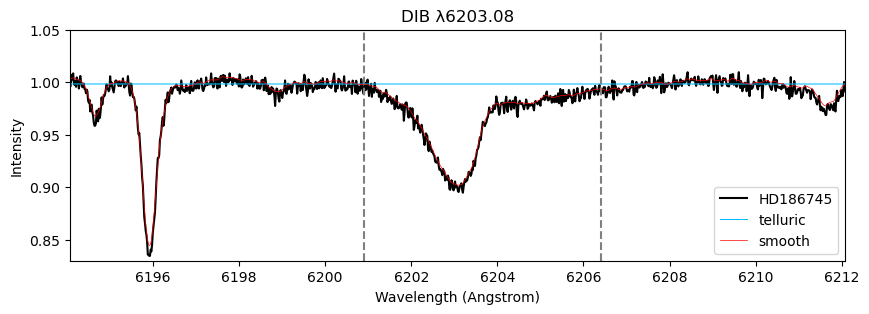

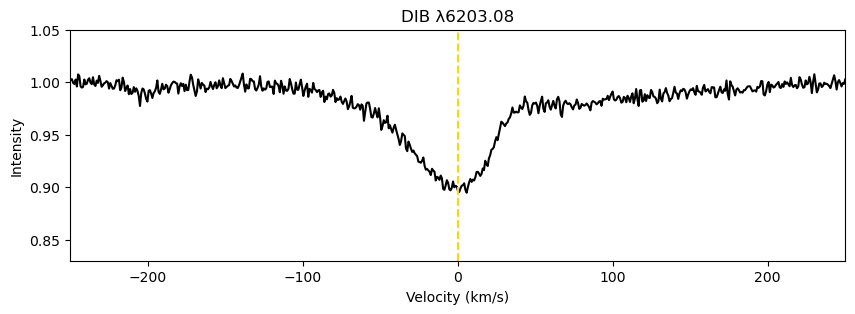

Central Wavelength :  6203.08
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [19]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order51.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV'] / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = 6200.9
ending = 6206.4
ylimmin=0.83
ylimmax=1.05
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6203.08
n = 9
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     4696.057948  1.001174    1.001576 -0.181570  4712.270298  4714.756008   
2     4696.071757  1.001904    1.001630 -0.202447  4723.014088  4730.388360   
3     4696.085567  0.999236    1.001736       NaN          NaN          NaN   
4     4696.099376  1.001343    1.001878       NaN          NaN          NaN   
5     4696.113186  1.001605    1.002034       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
4086  4752.469748  0.995332    0.998201       NaN          NaN          NaN   
4087  4752.483557  1.001203    0.998132       NaN          NaN          NaN   
4088  4752.497367  0.998564    0.998026       NaN          NaN          NaN   
4089  4752.511176  0.995991    0.997917       NaN          NaN          NaN   
4090  4752.524986  0.994528    0.997846       NaN          NaN          NaN   

          FWHM       Center    Height  
1     1.017

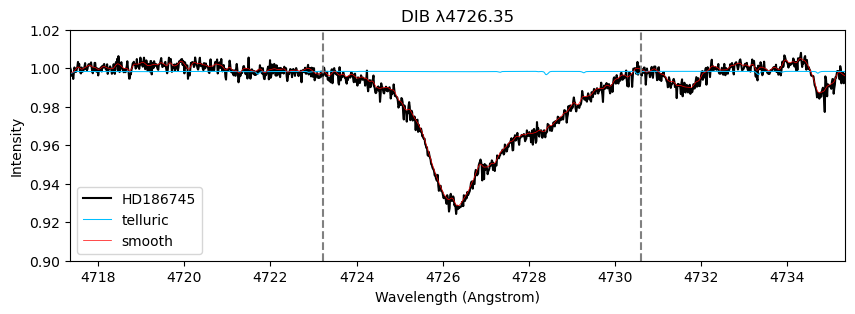

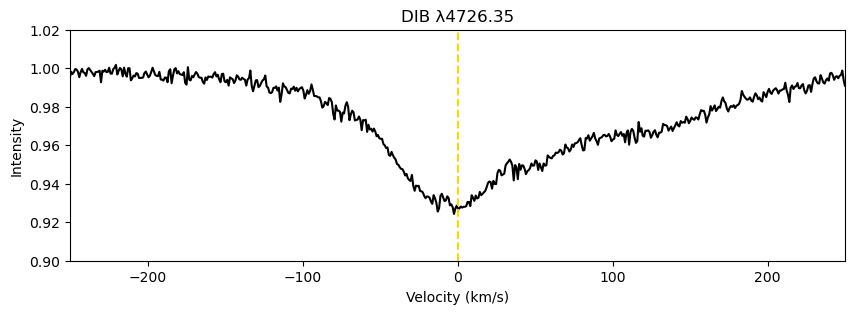

Central Wavelength :  4726.35
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [20]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order4.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV']  / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = (4723.014088) / (rv_corr/c_kms + 1)
ending = (4730.38836) / (rv_corr/c_kms + 1)
ylimmin=0.9
ylimmax=1.02
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 4726.35
n = 9
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [22]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysistriplets2(n1,n2,m,beginning1,beginning2, beginning3, ending1, ending2, ending3,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral1,restcentral2,restcentral3):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD186745')
    plt.plot(WV,FLUXSMOOTH,c='red',linewidth= 0.75,label='smooth')
#     plt.plot(telluricwv+m, telluricflux+0.003, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.axvline(x=beginning1, color='green', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral1}')
    plt.axvline(x=beginning2, color='purple', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral2}')
    plt.axvline(x=beginning3, color='brown', linestyle='dashed',linewidth=0.9,label=f'λ{restcentral3}')
    plt.axvline(x=ending1, color='green', linestyle='dashed',linewidth=0.9)
    plt.axvline(x=ending2, color='purple', linestyle='dashed',linewidth=0.9)
    plt.axvline(x=ending3, color='brown', linestyle='dashed',linewidth=0.9)
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'Triplets DIB λ{restcentral1}, λ{restcentral2}, & λ{restcentral3}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral1-n1,restcentral3+n2)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

#     v = velocity_doppler(WV,centervalue)
#     beginningnew = velocity_doppler(beginning,centervalue)
#     endingnew = velocity_doppler(ending,centervalue)
#     plt.figure(figsize=(10,3))
#     plt.plot(v,FLUX,c='black')
# #     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
# #     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
# #     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
#     plt.scatter(centervalue,0.9875,color='turquoise')
#     plt.xlabel('Velocity (km/s)')
#     plt.ylabel('Intensity')
#     plt.title(f'DIB λ{restcentral}')
#     plt.xlim(-xlimvel,xlimvel)
#     plt.ylim(ylimmin,ylimmax)
#     plt.show()
    

               WV   fluxori  fluxsmooth      Area  Beginning X     Ending X  \
1     6415.266434  0.993784    0.996670 -0.040217  6437.499281  6440.885413   
2     6415.282952  0.995895    0.996888 -0.053295  6444.370651  6447.756783   
3     6415.299470  0.997110    0.997312 -0.031678  6447.343840  6451.357645   
4     6415.315987  0.995671    0.997881 -0.105881  6453.587537  6458.873206   
5     6415.332505  0.997866    0.998514       NaN          NaN          NaN   
...           ...       ...         ...       ...          ...          ...   
4086  6482.741307  0.966567    0.964527       NaN          NaN          NaN   
4087  6482.757825  0.956645    0.964069       NaN          NaN          NaN   
4088  6482.774342  0.961082    0.963523       NaN          NaN          NaN   
4089  6482.790860  0.962237    0.963042       NaN          NaN          NaN   
4090  6482.807378  0.957471    0.962770       NaN          NaN          NaN   

          FWHM       Center    Height  
1     0.598

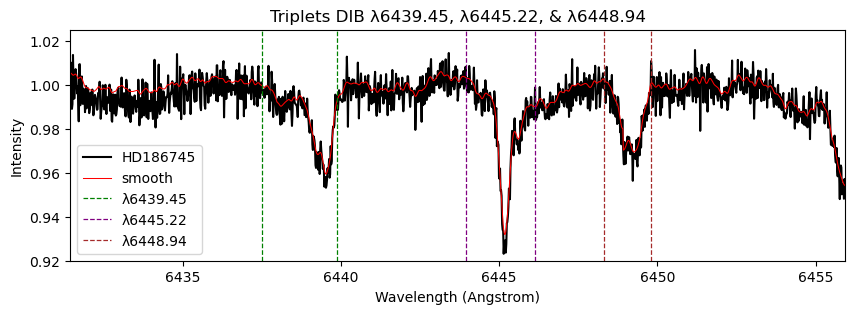

In [27]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order58.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','AreaIntgP(%)','Row Index','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2','Index'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV = (df['WV']) / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning1 = (6437.899281) / (rv_corr1/c_kms + 1)
ending1 = (6440.285413) / (rv_corr1/c_kms + 1)
restcentral1 = 6439.45
beginning2 = (6444.370651) / (rv_corr1/c_kms + 1)
ending2 = (6446.543840) / (rv_corr1/c_kms + 1)
restcentral2 = 6445.22
beginning3 = 6448.3
ending3 = 6449.8
restcentral3 = 6448.94

ylimmin=0.92
ylimmax=1.025
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
n1 = 8
n2 = 7
m = -3.2+0.3
s = 0.003

DIBSanalysistriplets2(n1,n2,m,beginning1,beginning2, beginning3, ending1, ending2, ending3,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral1,restcentral2,restcentral3)

In [33]:
#DIB 167971
def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def moleculeanalysis2(l,n,m,beginning,ending,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD186745')
    plt.plot(telluricwv+m, telluricflux+0.003, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.plot(WV,FLUXSMOOTH,c='red',label='smooth',linewidth = 0.45)
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='grey')
    plt.axvline(x=ending, color='grey')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'K I : λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-l,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,restcentral)
    beginningnew = velocity_doppler(beginning,restcentral)
    endingnew = velocity_doppler(ending,restcentral)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', restcentral)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth
1     7648.109331  1.013987    1.006712
2     7648.129392  1.006533    1.005637
3     7648.149454  1.003867    1.003783
4     7648.169515  1.001040    1.001297
5     7648.189576  0.995828    0.998319
...           ...       ...         ...
4972  7747.833262  1.009654    1.004130
4973  7747.853324  1.004453    1.002649
4974  7747.873385  0.992406    1.001096
4975  7747.893446  0.993774    0.999818
4976  7747.913507  0.997741    0.999096

[4976 rows x 3 columns]


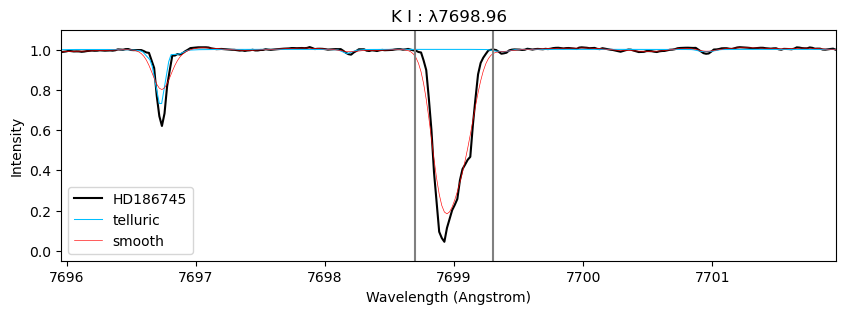

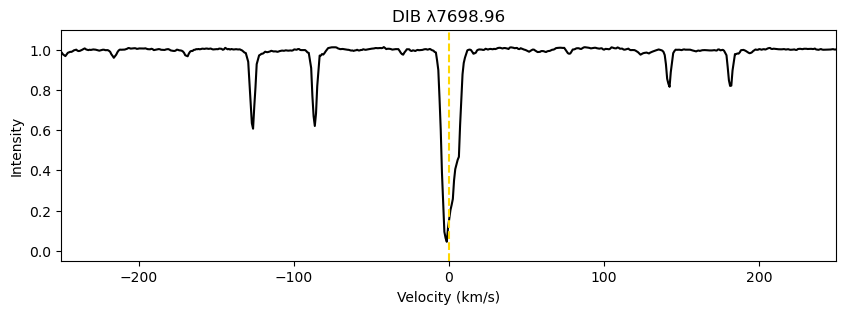

Central Wavelength :  7698.96
Eqivalent Width (mA):  183.95700000000002
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [34]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-B-order21.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)
k = 0
FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV = (df['WV']/(rv_corr/c_kms + 1)) + k
WV_f = WV / (rv_corr1/c_kms + 1)
WVbegin = 7698.7
WVend = 7699.3
WVcenter = (7701) / (rv_corr/c_kms + 1)
ylimmin=-0.05
ylimmax=1.1
EWvalue = (0.183957)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 7698.96

l=3
n=3
m=-6.43
telluricwv = telluricwv_combined2
telluricflux =  telluriccont_combined2

moleculeanalysis2(l,n,m,WVbegin,WVend,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

In [35]:

def velocity_doppler(lambda_n,lambda0):
    c= 299792.458
    d_lambda = lambda_n - lambda0 
    v = c * (d_lambda/lambda0)
    return v

def DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral):
    fluxcont = FLUX/FLUX
    plt.figure(figsize=(10,3))
    plt.plot(WV,FLUX,c='black',label='HD186745',alpha=0.4)
    plt.plot(telluricwv+m, telluricflux+0.003, c='deepskyblue', label='telluric',linewidth=0.75)
    plt.plot(WV,FLUXSMOOTH,c='red',label='smooth')
#     plt.plot(WV,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8,label='fc')
    plt.axvline(x=beginning, color='indigo', linestyle='dashed')
    plt.axvline(x=ending, color='indigo', linestyle='dashed')
#     plt.axvline(x=restcentral, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.title(f'DIB λ{restcentral}')
    plt.xlabel('Wavelength (Angstrom)')
    plt.ylabel('Intensity')
    plt.xlim(restcentral-n,restcentral+n)
    plt.ylim(ylimmin,ylimmax)
    plt.legend()
    plt.show()
    print("")
    

    v = velocity_doppler(WV,restcentral)
    beginningnew = velocity_doppler(beginning,restcentral)
    endingnew = velocity_doppler(ending,restcentral)
    plt.figure(figsize=(10,3))
    plt.plot(v,FLUX,c='black')
#     plt.plot(v,fluxcont,c='dodgerblue',linestyle='dashed',linewidth=0.8)
#     plt.axvline(x=beginningnew, color='lime', linestyle='dashed', alpha=0.5)
#     plt.axvline(x=endingnew, color='lime', linestyle='dashed', alpha=0.5)
    plt.axvline(x=0, color='gold', linestyle='dashed', label=f'λ{restcentral}')
    plt.xlabel('Velocity (km/s)')
    plt.ylabel('Intensity')
    plt.title(f'DIB λ{restcentral}')
    plt.xlim(-xlimvel,xlimvel)
    plt.ylim(ylimmin,ylimmax)
    plt.show()
    
    print('Central Wavelength : ', restcentral)
    print('Eqivalent Width (mA): ', EWvalue)
    print('FWHM (A): ', FWHMvalue)
    print('Optical Depth (%): ', tau)
    print('found in order ' + str(i) + ' part ' + str(j))

               WV   fluxori  fluxsmooth
1     6043.700397  0.986352    0.988215
2     6043.716915  0.985702    0.988206
3     6043.733433  0.985755    0.988263
4     6043.749950  0.984355    0.988464
5     6043.766468  0.983211    0.988871
...           ...       ...         ...
2041  6077.396539  0.994504    0.999024
2042  6077.413057  0.996333    0.999276
2043  6077.429575  0.999013    0.999493
2044  6077.446092  0.996480    0.999646
2045  6077.462610  0.994664    0.999725

[2045 rows x 3 columns]


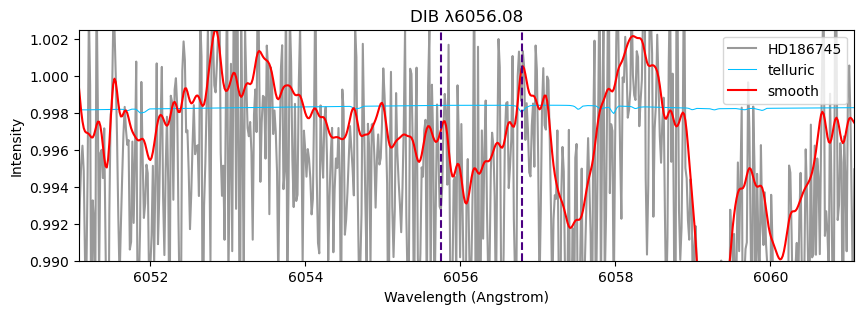

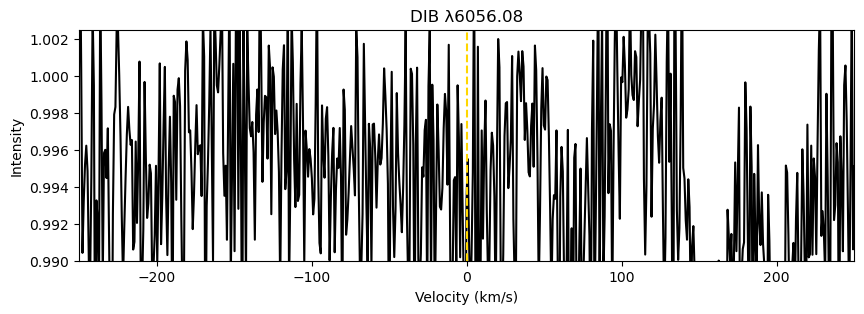

Central Wavelength :  6056.08
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [41]:
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-A-order47.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV'] / (rv_corr/c_kms + 1)
WV_f = WV / (rv_corr1/c_kms + 1)
beginning = 6055.75
ending = 6056.8
ylimmin=0.99
ylimmax=1.0025
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 6056.08
n = 5
m =  0
telluricwv = telluricwv_combined1
telluricflux =  telluriccont_combined1
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)

               WV   fluxori  fluxsmooth
1     7049.163911  0.968802    0.972150
2     7049.183972  0.971377    0.972088
3     7049.204033  0.970132    0.971962
4     7049.224094  0.970670    0.971774
5     7049.244155  0.966764    0.971518
...           ...       ...         ...
2484  7098.975723  0.988299    0.993594
2485  7098.995784  0.991147    0.994286
2486  7099.015846  0.993997    0.995156
2487  7099.035907  0.998602    0.995930
2488  7099.055968  0.998303    0.996372

[2488 rows x 3 columns]


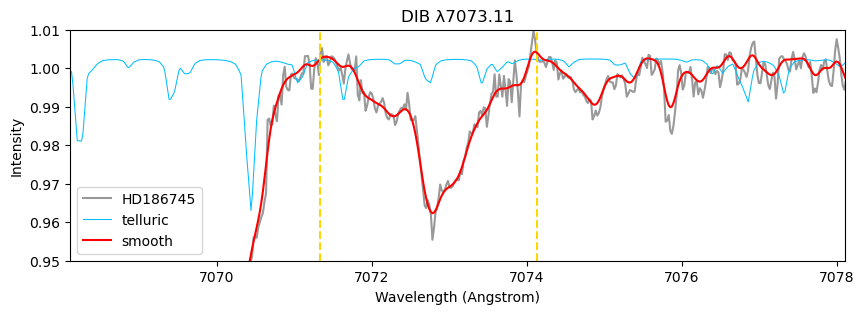

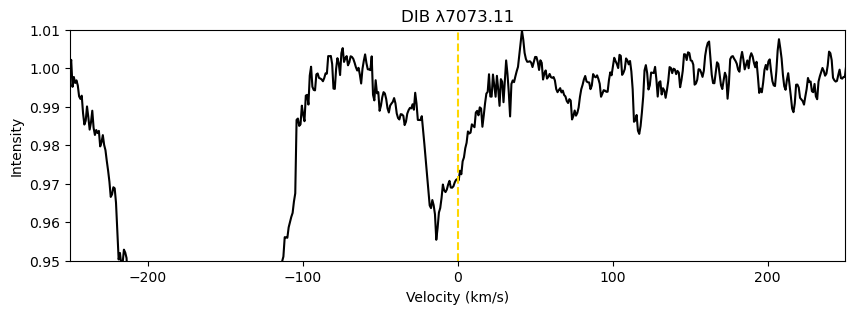

Central Wavelength :  7073.11
Eqivalent Width (mA):  536.9159999999999
FWHM (A):  2.120008
Optical Depth (%):  -23.0
found in order 0 part 0


In [271]:
rv_corr = -14.289302860876905
c_kms = (c/1000).value
df = pd.read_csv('./lineprofil/186745/trimHD186745-B-order8.csv')
df = df.rename(columns={'Unnamed: 0': 'WV', 'Unnamed: 7': 'fluxori', 'Unnamed: 8': 'fluxsmooth'})
df = df.drop(columns=['Unnamed: 1', 'Unnamed: 2','Baseline_Data X1', 'Baseline_Data Y1', 'Baseline_Data X2',
       'Baseline_Data Y2'])
df = df.drop(index=0)
# print(df.columns)
df = df.applymap(pd.to_numeric, errors='coerce')
print(df)

FLUX = df['fluxori']
FLUXSMOOTH = df['fluxsmooth']
WV =  df['WV'] + 3
WV_f = WV / (rv_corr/c_kms + 1)
beginning = (7071) / (rv_corr/c_kms + 1)
ending = (7073.8) / (rv_corr/c_kms + 1)
ylimmin=0.95
ylimmax=1.01
EWvalue = (0.536916)*1000
FWHMvalue = 2.120008
i=0
j=0
xlimvel=250
tau=(-0.23)*100
restcentral = 7073.11
n = 5
m =  0
telluricwv = telluricwv_combined2 + 3 - 2
telluricflux =  telluriccont_combined2
DIBSanalysis1(telluricwv,telluricflux,n,m,beginning,ending,WV_f,FLUX,FLUXSMOOTH,ylimmin,ylimmax,EWvalue,FWHMvalue,i,j,xlimvel,tau,restcentral)